## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.Compute the camera calibration using chessboard images

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import advanced_lane_lines as helpers
from lane_line import Line

%matplotlib qt


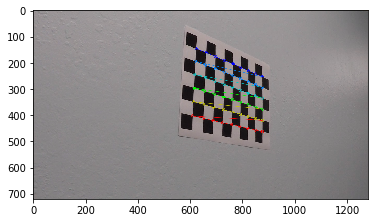

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
        plt.imshow(img)
# cv2.destroyAllWindows()


            
            

## 2. Apply a distortion correction to raw images.

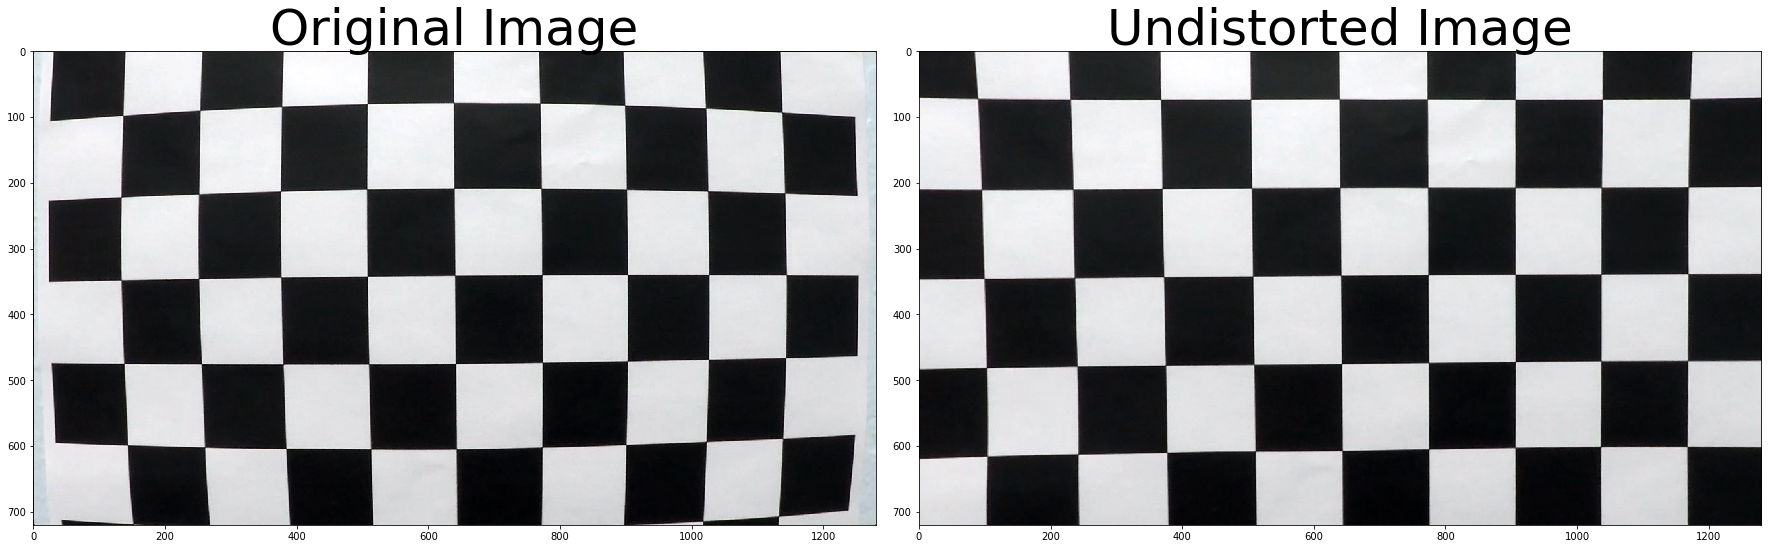

In [3]:
#========================================
#Test and show result
img = cv2.imread("./camera_cal/calibration1.jpg")

undistorted = helpers.cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

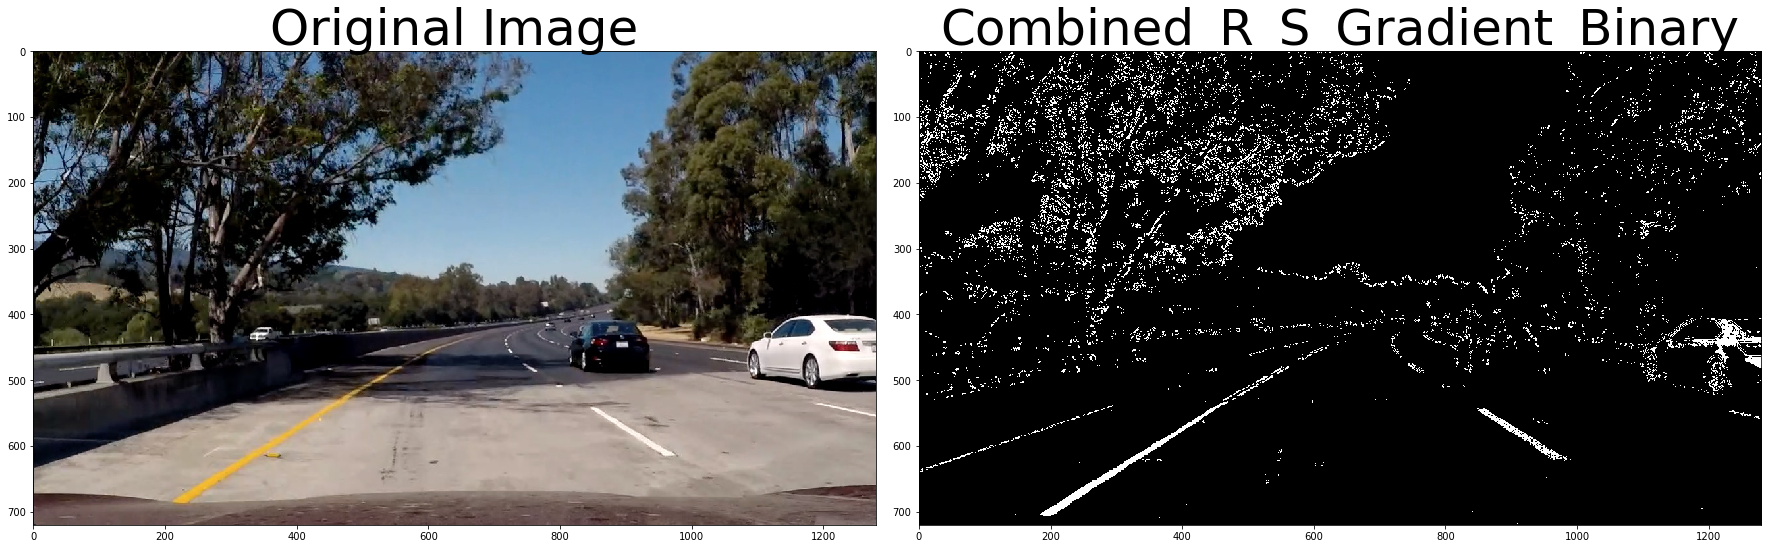

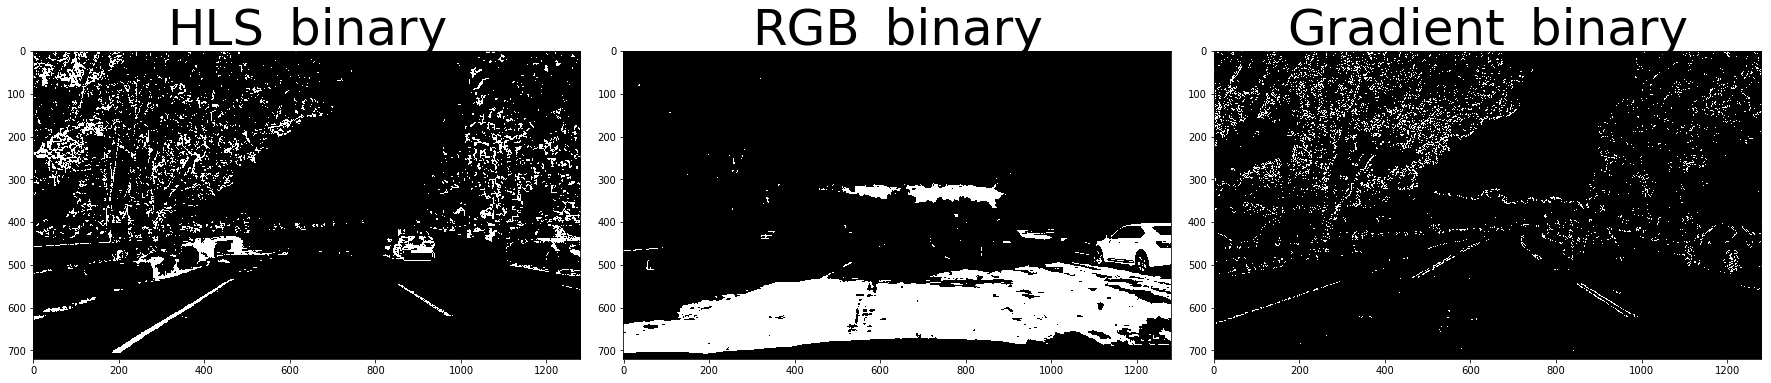

In [4]:
# Read in an image
# img = mpimg.imread('./test_images/test1.jpg') 
# img = mpimg.imread('./test_images/test2.jpg') 
# img = mpimg.imread('./test_images/test3.jpg') 
# img = mpimg.imread('./test_images/test4.jpg') 
img = mpimg.imread('./test_images/test5.jpg') 
# img = mpimg.imread('./test_images/test6.jpg') 
# img = mpimg.imread('./test_images/straight_lines1.jpg') 
# img = mpimg.imread('./test_images/straight_lines2.jpg') 

# img = mpimg.imread('./challenge_images/project_video_frames/challenge_149.jpg')
# img = mpimg.imread('./challenge_images/project_video_frames/challenge_157.jpg')
# img = mpimg.imread('./challenge_images/project_video_frames/challenge_159.jpg')
# img = mpimg.imread('./challenge_images/challenge_video_frames/challenge_53.jpg')

undistorted = helpers.cal_undistort(img, objpoints, imgpoints)

gradient_binary = helpers.combine_gradient_threshold(undistorted, sobel_kernel=3, abs_sobel_thresh=(20, 100),
                                                  mag_thresh=(30, 100), dir_threshold=(0.7, 1.3))

s_thresh_min = 170
s_thresh_max = 255

r_thresh_min = 170#200
r_thresh_max = 255

#经测试:R thresh 可以去掉阴影; S thresh在光线太强的区块表现较好;
hls_binary = helpers.hls_select(undistorted, thresh=(s_thresh_min, s_thresh_max))
rgb_binary = helpers.rgb_select(undistorted, thresh=(r_thresh_min, r_thresh_max))
combined_binary = np.zeros_like(gradient_binary)
# combined_binary[(hls_binary == 1)  | (gradient_binary == 1)] = 1
# combined_binary[(rgb_binary == 1)  | (gradient_binary == 1)] = 1
combined_binary[(hls_binary == 1) & (rgb_binary == 1) | (gradient_binary == 1)] = 1
# combined_binary[(hls_binary == 1) & (rgb_binary == 1) | (gradient_binary == 1) |(yellow_mask> 0)] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
# ax1.imshow(hls_binary, cmap='gray')
# ax1.imshow(gradient_binary, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined_R_S_Gradient_Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# # Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls_binary, cmap='gray')
ax1.set_title('HLS_binary', fontsize=50)
ax2.imshow(rgb_binary, cmap='gray')
ax2.set_title('RGB_binary', fontsize=50)
ax3.imshow(gradient_binary, cmap='gray')
ax3.set_title('Gradient_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

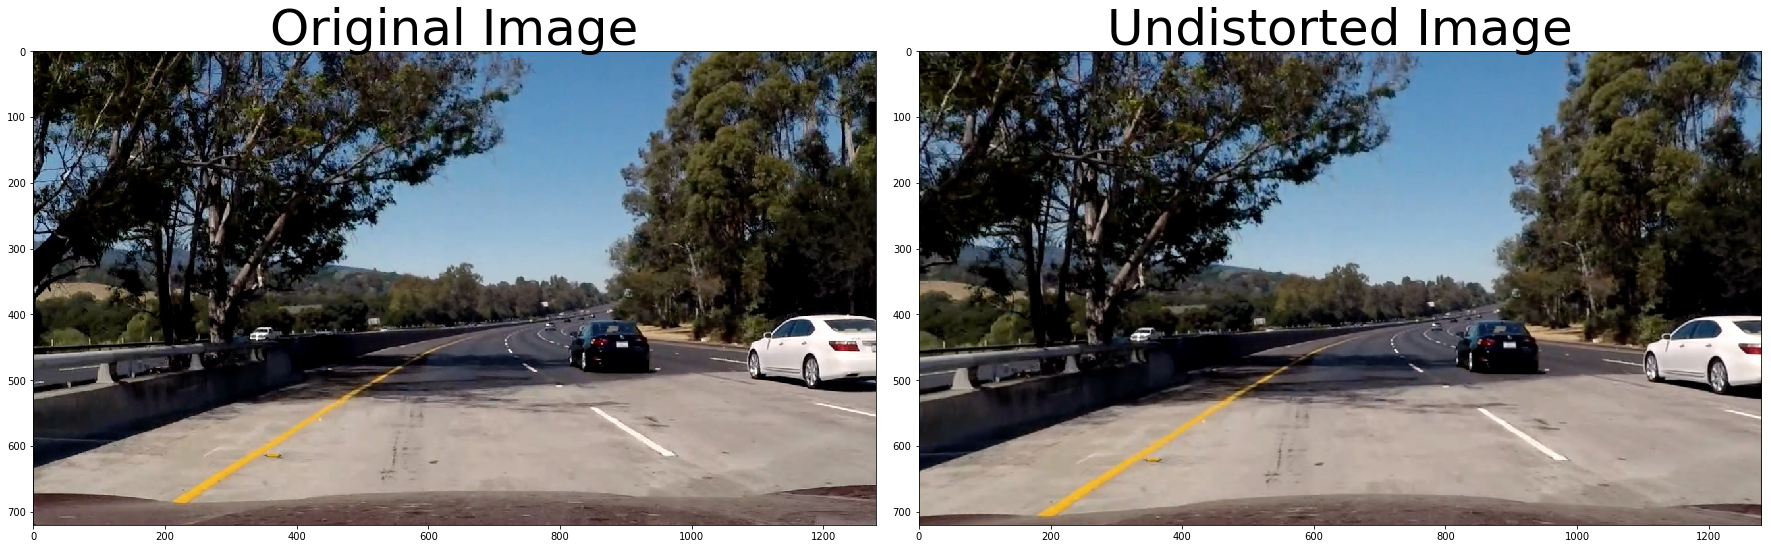

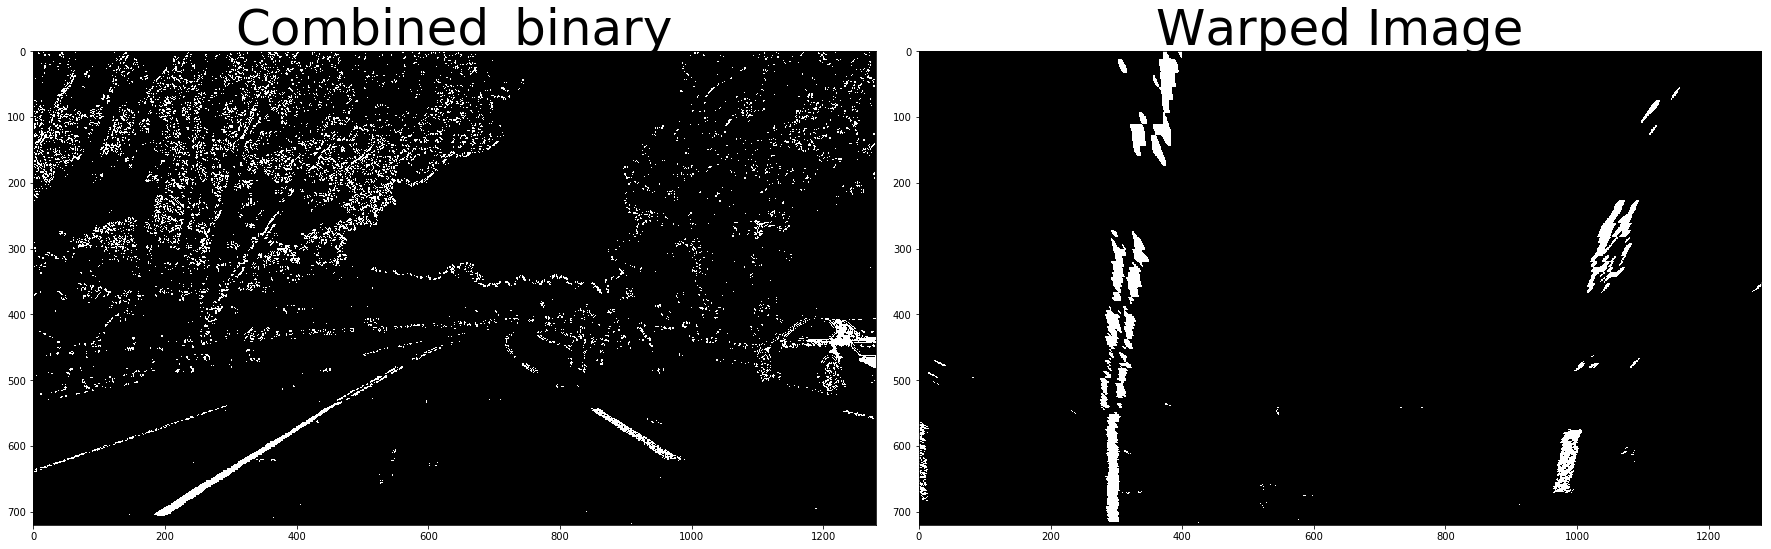

In [5]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# def warper(undist):
#     offset = 100
#     img_size = (undist.shape[1], undist.shape[0])

# #     src = np.float32([ [240, 720],[585,460], [695, 460], [1040, 720]])
# #     dst = np.float32([[320, 720], [320,0], [960, 0], [960, 720] ])
    
#     src = np.float32(
#     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#     [((img_size[0] / 6) - 10), img_size[1]],
#     [(img_size[0] * 5 / 6) + 60, img_size[1]],
#     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
#     dst = np.float32(
#         [[(img_size[0] / 4), 0],
#         [(img_size[0] / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), 0]])

#     M = cv2.getPerspectiveTransform(src, dst)
#     M_inverse = cv2.getPerspectiveTransform(dst, src)
#     warped = cv2.warpPerspective(undist, M, img_size)

#     print(src)
#     print(dst)
#     return warped, M_inverse

#=======================================================
# unwarped_img, M_inverse = warper(combined_binary)
unwarped_img, M_inverse = helpers.warper(combined_binary)

#=======================================================

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined_binary', fontsize=50)
ax2.imshow(unwarped_img, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Detect lane pixels and fit to find the lane boundary

search_by_sliding_window:
search_by_sliding_window:Done!
(720, 1280)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


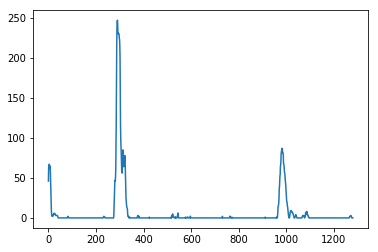

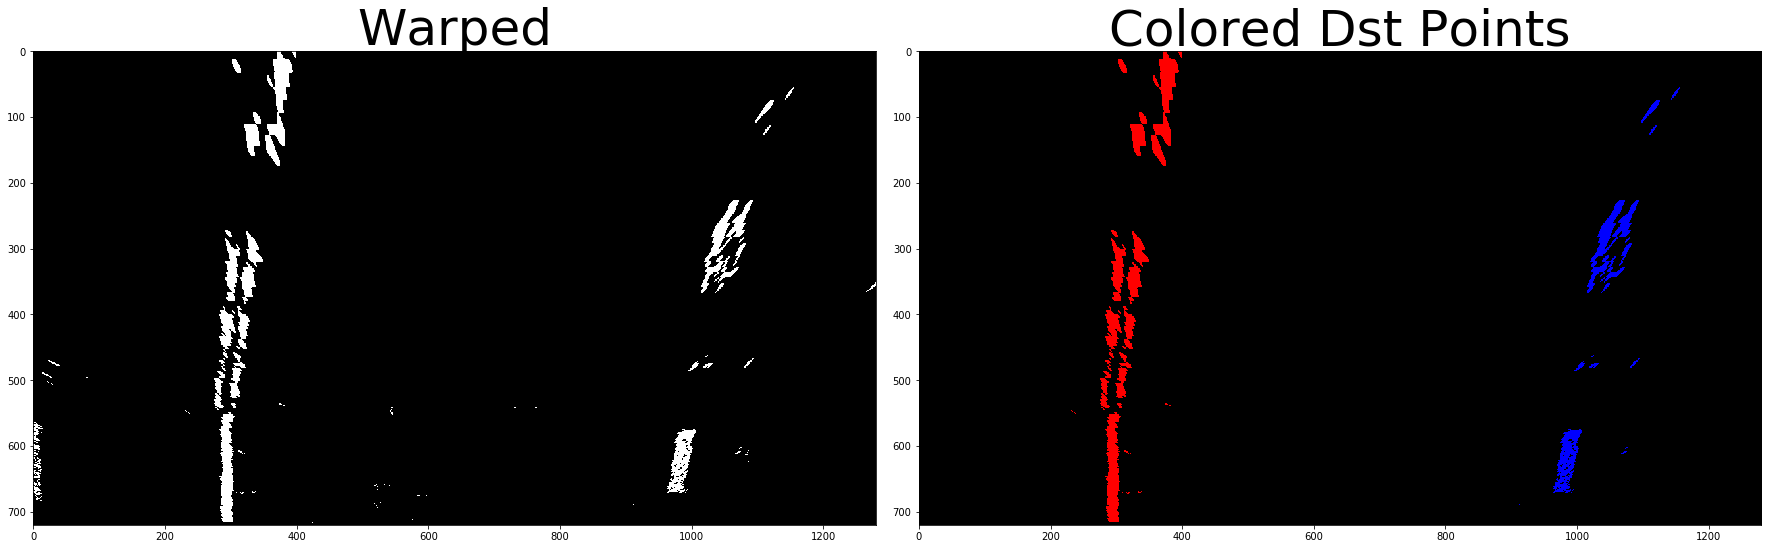

In [8]:

binary_warped = unwarped_img

#Test===================================
# Create histogram of image binary activations
histogram = helpers.hist(binary_warped)
# Visualize the resulting histogram
plt.plot(histogram)

left_line = Line()
right_line = Line()

# colored_lane_regions, warped, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(binary_warped)
left_line, right_line, colored_lane_regions = helpers.fit_polynomial_v2(binary_warped, left_line, right_line)

# mpimg.imsave("out_img.png", out_img)

# plt.imshow(out_img)
# plt.savefig('warped_example_output.png',dpi=400,bbox_inches='tight')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# ax1.imshow(warped)
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Warped', fontsize=50)
ax2.imshow(colored_lane_regions)
ax2.set_title('Colored Dst Points', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# mpimg.imsave('./warped_test5.png', binary_warped)
# print(binary_warped.shape)
# print(binary_warped)

## 6. Determine the curvature of the lane and vehicle position with respect to center

In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Calculate the radius of curvature in meters for both lane lines
# curvature, distance_from_center = measure_curvature_vehicle_position(unwarped_img, ploty, left_fit, right_fit)
curvature, distance_from_center = helpers.measure_curvature_vehicle_position(unwarped_img, left_line.current_fit, right_line.current_fit, ym_per_pix, xm_per_pix)
print("Radius of Curvature = %sm" % (round(curvature)))
print("Vehicle is %.3fm of center" % (abs(distance_from_center)))

Radius of Curvature = 311.0m
Vehicle is 0.421m of center


## 7. Warp the detected lane boundaries back onto the original image

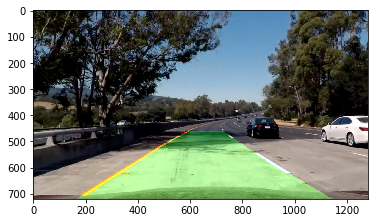

In [18]:
#Test============================= 
# result = warp_lane_boundaries_onto_origin(undistorted, warped,colored_lane_regions, left_fitx, right_fitx, ploty, M_inverse)
result = helpers.warp_lane_boundaries_onto_origin(undistorted, binary_warped, left_line, right_line, M_inverse)
mpimg.imsave('./output_images/warped_output.png', result)

plt.imshow(result)
# plt.savefig('warped_output.png',dpi=400,bbox_inches='tight')    

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

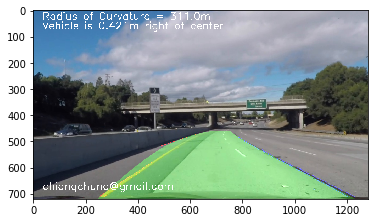

In [9]:
output_img = helpers.draw_curvature_vehicle_position_info(result, curvature, distance_from_center)
mpimg.imsave('./output_images/warped_output.png', output_img)
plt.imshow(result)

In [26]:
images = glob.glob('./camera_cal/calibration*.jpg')
objpoints, imgpoints = helpers.get_objpoints_imgpoints(images)
s_thresh_min = 170
s_thresh_max = 255

r_thresh_min = 170#200
r_thresh_max = 255

left_line = Line()
right_line = Line()

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def process_image(img):
    
    undistorted = helpers.cal_undistort(img, objpoints, imgpoints)
    
    #Use color transforms, gradients, etc., to create a thresholded binary image
    gradient_binary = helpers.combine_gradient_threshold(undistorted, sobel_kernel=3, abs_sobel_thresh=(20, 100),
                                                  mag_thresh=(30, 100), dir_threshold=(0.7, 1.3))
    #经测试:R thresh 可以去掉阴影; S thresh在光线太强的区块表现较好;
    hls_binary = helpers.hls_select(undistorted, thresh=(s_thresh_min, s_thresh_max))

    rgb_binary = helpers.rgb_select(undistorted, thresh=(r_thresh_min, r_thresh_max))

    combined_binary = np.zeros_like(gradient_binary)
#     combined_binary[(hls_binary == 1) | (gradient_binary == 1)] = 1
    combined_binary[(hls_binary == 1) & (rgb_binary == 1) | (gradient_binary == 1)] = 1

    #Apply perspective transform
    warped_img, M_inverse = helpers.warper(combined_binary)
    
    global left_line
    global right_line
    #Detect lane pixels and fit to find the lane boundary
    left_line, right_line, colored_lane_regions = helpers.fit_polynomial_v2(warped_img, left_line, right_line)
    
    #Warp the detected lane boundaries back onto the original image
    result = helpers.warp_lane_boundaries_onto_origin(undistorted, binary_warped, left_line, right_line, M_inverse)
    
    curvature, distance_from_center = helpers.measure_curvature_vehicle_position(unwarped_img, left_line.current_fit, right_line.current_fit, ym_per_pix, xm_per_pix)
    
    result = helpers.draw_curvature_vehicle_position_info(result, curvature, distance_from_center)
    
    return result

In [27]:
def process_video(src_video, output_path):
#     clip1 = VideoFileClip(src_video).subclip(5,10)
    clip1 = VideoFileClip(src_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_path, audio=False)

### 8.1 project_video.mp4

In [12]:
src_video = "project_video.mp4"
output_path = "output_videos/test_project_video.mp4"

#Wall time: 26min 4s v1
#Wall time: 30min 56s v2
#Wall time: 3min 8s (0, 5)
#Wall time: 2min 40s v3(0, 5)
#Wall time: 27min 6s v3
test_project_video = process_video(src_video, output_path)

# test_project_video = 'output_videos/test_project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# white_clip = clip1.fl_image(process_image)
# %time white_clip.write_videofile(test_project_video, audio=False)

search_by_sliding_window:
search_by_sliding_window:Done!
Moviepy - Building video output_videos/test_project_video.mp4.
Moviepy - Writing video output_videos/test_project_video.mp4



t:   0%|                                    | 0/1260 [00:00<?, ?it/s, now=None]

search_lines_from_prior:Success


t:   0%|                            | 2/1260 [00:01<15:28,  1.36it/s, now=None]

search_lines_from_prior:Success


t:   0%|                            | 3/1260 [00:02<19:34,  1.07it/s, now=None]

search_lines_from_prior:Success


t:   0%|                            | 4/1260 [00:04<22:13,  1.06s/it, now=None]

search_lines_from_prior:Success


t:   0%|                            | 5/1260 [00:05<24:35,  1.18s/it, now=None]

search_lines_from_prior:Success


t:   0%|▏                           | 6/1260 [00:06<25:08,  1.20s/it, now=None]

search_lines_from_prior:Success


t:   1%|▏                           | 7/1260 [00:08<25:39,  1.23s/it, now=None]

search_lines_from_prior:Success


t:   1%|▏                           | 8/1260 [00:09<26:18,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   1%|▏                           | 9/1260 [00:10<26:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   1%|▏                          | 10/1260 [00:12<26:46,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   1%|▏                          | 11/1260 [00:13<26:56,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   1%|▎                          | 12/1260 [00:14<26:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   1%|▎                          | 13/1260 [00:16<26:58,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   1%|▎                          | 14/1260 [00:17<27:07,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   1%|▎                          | 15/1260 [00:18<26:54,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   1%|▎                          | 16/1260 [00:19<26:43,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   1%|▎                          | 17/1260 [00:21<27:48,  1.34s/it, now=None]

search_lines_from_prior:Success


t:   1%|▍                          | 18/1260 [00:22<27:56,  1.35s/it, now=None]

search_lines_from_prior:Success


t:   2%|▍                          | 19/1260 [00:24<27:34,  1.33s/it, now=None]

search_lines_from_prior:Success


t:   2%|▍                          | 20/1260 [00:25<27:22,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   2%|▍                          | 21/1260 [00:26<27:14,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   2%|▍                          | 22/1260 [00:27<26:53,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   2%|▍                          | 23/1260 [00:29<27:04,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                          | 24/1260 [00:30<26:45,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                          | 25/1260 [00:31<27:01,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                          | 26/1260 [00:33<26:54,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                          | 27/1260 [00:34<26:39,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                          | 28/1260 [00:35<26:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                          | 29/1260 [00:37<26:59,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   2%|▋                          | 30/1260 [00:38<26:55,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   2%|▋                          | 31/1260 [00:39<26:40,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   3%|▋                          | 32/1260 [00:41<26:42,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   3%|▋                          | 33/1260 [00:42<26:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   3%|▋                          | 34/1260 [00:43<26:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                          | 35/1260 [00:44<26:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                          | 36/1260 [00:46<26:17,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                          | 37/1260 [00:47<26:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                          | 38/1260 [00:48<27:17,  1.34s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                          | 39/1260 [00:50<26:54,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                          | 40/1260 [00:51<26:37,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   3%|▉                          | 41/1260 [00:53<28:50,  1.42s/it, now=None]

search_lines_from_prior:Success


t:   3%|▉                          | 42/1260 [00:54<29:27,  1.45s/it, now=None]

search_lines_from_prior:Success


t:   3%|▉                          | 43/1260 [00:56<28:46,  1.42s/it, now=None]

search_lines_from_prior:Success


t:   3%|▉                          | 44/1260 [00:57<28:10,  1.39s/it, now=None]

search_lines_from_prior:Success


t:   4%|▉                          | 45/1260 [00:58<27:38,  1.36s/it, now=None]

search_lines_from_prior:Success


t:   4%|▉                          | 46/1260 [00:59<26:55,  1.33s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                          | 47/1260 [01:01<26:46,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                          | 48/1260 [01:02<26:40,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                          | 49/1260 [01:03<26:32,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                          | 50/1260 [01:05<26:23,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                          | 51/1260 [01:06<26:04,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                          | 52/1260 [01:07<26:01,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   4%|█▏                         | 53/1260 [01:09<26:24,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   4%|█▏                         | 54/1260 [01:10<26:03,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   4%|█▏                         | 55/1260 [01:11<25:59,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   4%|█▏                         | 56/1260 [01:12<26:12,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▏                         | 57/1260 [01:14<26:26,  1.32s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▏                         | 58/1260 [01:15<26:19,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                         | 59/1260 [01:16<26:10,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                         | 60/1260 [01:18<25:44,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                         | 61/1260 [01:19<25:49,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                         | 62/1260 [01:20<25:51,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                         | 63/1260 [01:21<25:31,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                         | 64/1260 [01:23<25:17,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▍                         | 65/1260 [01:24<25:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▍                         | 66/1260 [01:25<25:35,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▍                         | 67/1260 [01:27<25:26,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▍                         | 68/1260 [01:28<25:17,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▍                         | 69/1260 [01:29<25:39,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                         | 70/1260 [01:30<25:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                         | 71/1260 [01:32<25:33,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                         | 72/1260 [01:33<25:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                         | 73/1260 [01:34<25:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                         | 74/1260 [01:36<25:41,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                         | 75/1260 [01:37<25:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                         | 76/1260 [01:38<25:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                         | 77/1260 [01:40<25:21,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                         | 78/1260 [01:41<25:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                         | 79/1260 [01:42<25:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                         | 80/1260 [01:43<25:42,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                         | 81/1260 [01:45<25:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▊                         | 82/1260 [01:46<25:30,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▊                         | 83/1260 [01:47<25:18,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▊                         | 84/1260 [01:49<25:07,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▊                         | 85/1260 [01:50<25:03,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▊                         | 86/1260 [01:51<25:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▊                         | 87/1260 [01:52<25:11,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                         | 88/1260 [01:54<24:59,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                         | 89/1260 [01:55<25:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                         | 90/1260 [01:56<25:29,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                         | 91/1260 [01:58<25:19,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                         | 92/1260 [01:59<25:07,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                         | 93/1260 [02:00<24:57,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   7%|██                         | 94/1260 [02:02<25:22,  1.31s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                         | 95/1260 [02:03<25:04,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                         | 96/1260 [02:04<24:58,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                         | 97/1260 [02:05<24:49,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                         | 98/1260 [02:07<25:15,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                         | 99/1260 [02:08<25:00,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                        | 100/1260 [02:09<24:56,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                        | 101/1260 [02:11<24:49,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██                        | 102/1260 [02:12<24:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▏                       | 103/1260 [02:13<24:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▏                       | 104/1260 [02:14<24:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▏                       | 105/1260 [02:16<24:36,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▏                       | 106/1260 [02:17<24:33,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▏                       | 107/1260 [02:18<24:55,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▏                       | 108/1260 [02:20<24:39,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▏                       | 109/1260 [02:21<24:27,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▎                       | 110/1260 [02:22<24:44,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▎                       | 111/1260 [02:23<24:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▎                       | 112/1260 [02:25<24:27,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▎                       | 113/1260 [02:26<24:27,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▎                       | 114/1260 [02:27<24:19,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▎                       | 115/1260 [02:28<24:24,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▍                       | 116/1260 [02:30<24:29,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▍                       | 117/1260 [02:31<24:19,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▍                       | 118/1260 [02:32<24:13,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▍                       | 119/1260 [02:34<24:44,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▍                       | 120/1260 [02:35<24:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▍                       | 121/1260 [02:36<24:22,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▌                       | 122/1260 [02:38<24:44,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▌                       | 123/1260 [02:39<24:34,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▌                       | 124/1260 [02:40<24:26,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▌                       | 125/1260 [02:41<24:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▌                       | 126/1260 [02:43<24:12,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▌                       | 127/1260 [02:44<24:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▋                       | 128/1260 [02:45<24:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▋                       | 129/1260 [02:47<24:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▋                       | 130/1260 [02:48<24:01,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▋                       | 131/1260 [02:49<24:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▋                       | 132/1260 [02:50<24:14,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▋                       | 133/1260 [02:52<23:59,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▊                       | 134/1260 [02:53<24:03,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▊                       | 135/1260 [02:54<23:56,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▊                       | 136/1260 [02:55<23:55,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▊                       | 137/1260 [02:57<24:04,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▊                       | 138/1260 [02:58<24:00,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▊                       | 139/1260 [02:59<23:58,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▉                       | 140/1260 [03:01<24:35,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▉                       | 141/1260 [03:02<24:24,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▉                       | 142/1260 [03:03<24:07,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▉                       | 143/1260 [03:05<24:00,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▉                       | 144/1260 [03:06<24:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  12%|██▉                       | 145/1260 [03:07<23:58,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███                       | 146/1260 [03:08<23:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███                       | 147/1260 [03:10<23:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  12%|███                       | 148/1260 [03:11<23:57,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███                       | 149/1260 [03:12<23:51,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███                       | 150/1260 [03:14<23:36,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  12%|███                       | 151/1260 [03:15<23:23,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▏                      | 152/1260 [03:16<23:49,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▏                      | 153/1260 [03:17<23:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▏                      | 154/1260 [03:19<23:31,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▏                      | 155/1260 [03:20<23:32,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▏                      | 156/1260 [03:21<23:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▏                      | 157/1260 [03:23<23:40,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▎                      | 158/1260 [03:24<23:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▎                      | 159/1260 [03:25<23:32,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▎                      | 160/1260 [03:26<23:22,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▎                      | 161/1260 [03:28<23:46,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▎                      | 162/1260 [03:29<23:33,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▎                      | 163/1260 [03:30<23:23,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▍                      | 164/1260 [03:32<23:36,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▍                      | 165/1260 [03:33<23:49,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▍                      | 166/1260 [03:34<23:38,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▍                      | 167/1260 [03:35<23:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▍                      | 168/1260 [03:37<23:16,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▍                      | 169/1260 [03:38<23:26,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▌                      | 170/1260 [03:39<23:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▌                      | 171/1260 [03:41<23:14,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▌                      | 172/1260 [03:42<23:00,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▌                      | 173/1260 [03:43<23:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▌                      | 174/1260 [03:44<23:14,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▌                      | 175/1260 [03:46<23:06,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▋                      | 176/1260 [03:47<23:12,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▋                      | 177/1260 [03:48<23:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▋                      | 178/1260 [03:50<23:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▋                      | 179/1260 [03:51<23:18,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▋                      | 180/1260 [03:52<23:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▋                      | 181/1260 [03:53<23:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▊                      | 182/1260 [03:55<23:28,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▊                      | 183/1260 [03:56<23:32,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▊                      | 184/1260 [03:57<23:16,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▊                      | 185/1260 [03:59<23:22,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▊                      | 186/1260 [04:00<23:22,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▊                      | 187/1260 [04:01<23:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▉                      | 188/1260 [04:03<23:29,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▉                      | 189/1260 [04:04<23:15,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▉                      | 190/1260 [04:05<23:18,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▉                      | 191/1260 [04:07<23:11,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▉                      | 192/1260 [04:08<22:47,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  15%|███▉                      | 193/1260 [04:09<22:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  15%|████                      | 194/1260 [04:10<23:13,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  15%|████                      | 195/1260 [04:12<22:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  16%|████                      | 196/1260 [04:13<22:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  16%|████                      | 197/1260 [04:14<22:51,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  16%|████                      | 198/1260 [04:16<22:56,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  16%|████                      | 199/1260 [04:17<22:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▏                     | 200/1260 [04:18<22:45,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▏                     | 201/1260 [04:19<22:36,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▏                     | 202/1260 [04:21<22:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▏                     | 203/1260 [04:22<22:52,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▏                     | 204/1260 [04:23<22:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▏                     | 205/1260 [04:25<22:31,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▎                     | 206/1260 [04:26<22:52,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▎                     | 207/1260 [04:27<22:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▎                     | 208/1260 [04:28<22:33,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▎                     | 209/1260 [04:30<22:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▎                     | 210/1260 [04:31<22:41,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▎                     | 211/1260 [04:32<22:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▎                     | 212/1260 [04:34<22:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▍                     | 213/1260 [04:35<22:18,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▍                     | 214/1260 [04:36<22:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▍                     | 215/1260 [04:37<22:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▍                     | 216/1260 [04:39<22:16,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▍                     | 217/1260 [04:40<22:17,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▍                     | 218/1260 [04:41<22:12,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▌                     | 219/1260 [04:43<22:17,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▌                     | 220/1260 [04:44<22:05,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▌                     | 221/1260 [04:45<22:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▌                     | 222/1260 [04:46<22:11,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▌                     | 223/1260 [04:48<22:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▌                     | 224/1260 [04:49<22:22,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▋                     | 225/1260 [04:50<22:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▋                     | 226/1260 [04:52<22:04,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▋                     | 227/1260 [04:53<22:36,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▋                     | 228/1260 [04:54<22:23,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▋                     | 229/1260 [04:56<22:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▋                     | 230/1260 [04:57<22:11,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▊                     | 231/1260 [04:58<22:19,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▊                     | 232/1260 [04:59<22:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▊                     | 233/1260 [05:01<22:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▊                     | 234/1260 [05:02<22:01,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▊                     | 235/1260 [05:03<22:18,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▊                     | 236/1260 [05:05<22:05,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▉                     | 237/1260 [05:06<21:52,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▉                     | 238/1260 [05:07<21:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▉                     | 239/1260 [05:08<22:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▉                     | 240/1260 [05:10<21:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▉                     | 241/1260 [05:11<21:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|████▉                     | 242/1260 [05:12<21:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████                     | 243/1260 [05:14<21:47,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████                     | 244/1260 [05:15<21:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████                     | 245/1260 [05:16<21:49,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████                     | 246/1260 [05:17<21:37,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████                     | 247/1260 [05:19<21:30,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████                     | 248/1260 [05:20<21:57,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▏                    | 249/1260 [05:21<21:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▏                    | 250/1260 [05:23<21:30,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▏                    | 251/1260 [05:24<21:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▏                    | 252/1260 [05:25<21:40,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▏                    | 253/1260 [05:26<21:32,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▏                    | 254/1260 [05:28<21:25,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▎                    | 255/1260 [05:29<21:23,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▎                    | 256/1260 [05:30<21:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▎                    | 257/1260 [05:32<21:25,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▎                    | 258/1260 [05:33<21:19,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▎                    | 259/1260 [05:34<21:17,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▎                    | 260/1260 [05:35<21:38,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▍                    | 261/1260 [05:37<21:27,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▍                    | 262/1260 [05:38<21:21,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▍                    | 263/1260 [05:39<21:19,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▍                    | 264/1260 [05:41<21:27,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▍                    | 265/1260 [05:42<21:15,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▍                    | 266/1260 [05:43<21:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▌                    | 267/1260 [05:44<21:12,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▌                    | 268/1260 [05:46<21:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▌                    | 269/1260 [05:47<21:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▌                    | 270/1260 [05:48<21:14,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▌                    | 271/1260 [05:50<21:04,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▌                    | 272/1260 [05:51<21:18,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▋                    | 273/1260 [05:52<21:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▋                    | 274/1260 [05:53<21:14,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▋                    | 275/1260 [05:55<21:21,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▋                    | 276/1260 [05:56<21:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▋                    | 277/1260 [05:57<21:16,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▋                    | 278/1260 [05:59<21:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▊                    | 279/1260 [06:00<20:57,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▊                    | 280/1260 [06:01<20:58,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▊                    | 281/1260 [06:03<21:43,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▊                    | 282/1260 [06:04<21:31,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▊                    | 283/1260 [06:05<21:12,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  23%|█████▊                    | 284/1260 [06:07<21:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  23%|█████▉                    | 285/1260 [06:08<21:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  23%|█████▉                    | 286/1260 [06:09<20:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  23%|█████▉                    | 287/1260 [06:10<20:48,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  23%|█████▉                    | 288/1260 [06:12<20:40,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  23%|█████▉                    | 289/1260 [06:13<20:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  23%|█████▉                    | 290/1260 [06:14<21:08,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████                    | 291/1260 [06:16<20:49,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████                    | 292/1260 [06:17<20:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████                    | 293/1260 [06:18<20:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████                    | 294/1260 [06:19<20:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████                    | 295/1260 [06:21<20:34,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████                    | 296/1260 [06:22<20:40,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▏                   | 297/1260 [06:23<20:57,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▏                   | 298/1260 [06:25<20:44,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▏                   | 299/1260 [06:26<20:43,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▏                   | 300/1260 [06:27<20:35,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▏                   | 301/1260 [06:28<20:35,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▏                   | 302/1260 [06:30<20:45,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▎                   | 303/1260 [06:31<20:40,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▎                   | 304/1260 [06:32<20:42,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▎                   | 305/1260 [06:34<20:47,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▎                   | 306/1260 [06:35<20:49,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▎                   | 307/1260 [06:36<20:39,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▎                   | 308/1260 [06:38<20:34,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▍                   | 309/1260 [06:39<20:29,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▍                   | 310/1260 [06:40<20:48,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▍                   | 311/1260 [06:42<20:46,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▍                   | 312/1260 [06:43<20:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▍                   | 313/1260 [06:44<20:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▍                   | 314/1260 [06:45<21:00,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                   | 315/1260 [06:47<20:41,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                   | 316/1260 [06:48<20:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                   | 317/1260 [06:49<20:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                   | 318/1260 [06:51<20:31,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                   | 319/1260 [06:52<20:24,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                   | 320/1260 [06:53<20:32,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                   | 321/1260 [06:55<20:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▋                   | 322/1260 [06:56<20:24,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▋                   | 323/1260 [06:57<20:24,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▋                   | 324/1260 [06:58<20:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▋                   | 325/1260 [07:00<20:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▋                   | 326/1260 [07:01<20:25,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▋                   | 327/1260 [07:02<20:20,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▊                   | 328/1260 [07:04<20:09,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▊                   | 329/1260 [07:05<20:07,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▊                   | 330/1260 [07:06<20:09,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▊                   | 331/1260 [07:08<20:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▊                   | 332/1260 [07:09<20:01,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▊                   | 333/1260 [07:10<19:51,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  27%|██████▉                   | 334/1260 [07:11<20:06,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  27%|██████▉                   | 335/1260 [07:13<20:01,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  27%|██████▉                   | 336/1260 [07:14<19:56,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  27%|██████▉                   | 337/1260 [07:15<19:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  27%|██████▉                   | 338/1260 [07:17<20:00,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  27%|██████▉                   | 339/1260 [07:18<19:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████                   | 340/1260 [07:19<19:51,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████                   | 341/1260 [07:21<20:00,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████                   | 342/1260 [07:22<19:52,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████                   | 343/1260 [07:23<19:54,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████                   | 344/1260 [07:24<19:50,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████                   | 345/1260 [07:26<19:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████▏                  | 346/1260 [07:27<19:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▏                  | 347/1260 [07:28<19:59,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▏                  | 348/1260 [07:30<19:39,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▏                  | 349/1260 [07:31<19:29,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▏                  | 350/1260 [07:32<19:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▏                  | 351/1260 [07:33<19:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▎                  | 352/1260 [07:35<19:27,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▎                  | 353/1260 [07:36<19:29,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▎                  | 354/1260 [07:37<19:23,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▎                  | 355/1260 [07:39<19:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▎                  | 356/1260 [07:40<19:27,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▎                  | 357/1260 [07:41<19:22,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▍                  | 358/1260 [07:42<19:20,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▍                  | 359/1260 [07:44<19:40,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▍                  | 360/1260 [07:45<19:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▍                  | 361/1260 [07:46<19:20,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▍                  | 362/1260 [07:48<19:17,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▍                  | 363/1260 [07:49<19:17,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▌                  | 364/1260 [07:50<19:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▌                  | 365/1260 [07:51<19:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▌                  | 366/1260 [07:53<19:00,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▌                  | 367/1260 [07:54<19:11,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▌                  | 368/1260 [07:55<19:33,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▌                  | 369/1260 [07:57<19:37,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▋                  | 370/1260 [07:58<19:22,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▋                  | 371/1260 [07:59<19:31,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▋                  | 372/1260 [08:01<19:15,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▋                  | 373/1260 [08:02<19:31,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▋                  | 374/1260 [08:03<19:36,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▋                  | 375/1260 [08:05<19:25,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▊                  | 376/1260 [08:06<19:16,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▊                  | 377/1260 [08:07<19:15,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▊                  | 378/1260 [08:08<18:58,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▊                  | 379/1260 [08:10<19:02,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▊                  | 380/1260 [08:11<19:11,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▊                  | 381/1260 [08:12<18:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▉                  | 382/1260 [08:14<18:41,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▉                  | 383/1260 [08:15<18:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  30%|███████▉                  | 384/1260 [08:16<18:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  31%|███████▉                  | 385/1260 [08:17<18:34,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  31%|███████▉                  | 386/1260 [08:19<18:35,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  31%|███████▉                  | 387/1260 [08:20<18:34,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████                  | 388/1260 [08:21<18:41,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████                  | 389/1260 [08:23<18:35,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████                  | 390/1260 [08:24<18:24,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████                  | 391/1260 [08:25<18:26,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████                  | 392/1260 [08:26<18:43,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████                  | 393/1260 [08:28<18:32,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▏                 | 394/1260 [08:29<18:27,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▏                 | 395/1260 [08:30<18:29,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▏                 | 396/1260 [08:32<18:26,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▏                 | 397/1260 [08:33<18:24,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▏                 | 398/1260 [08:34<18:26,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▏                 | 399/1260 [08:35<18:17,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▎                 | 400/1260 [08:37<18:15,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▎                 | 401/1260 [08:38<18:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▎                 | 402/1260 [08:39<18:21,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▎                 | 403/1260 [08:41<18:15,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▎                 | 404/1260 [08:42<18:29,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▎                 | 405/1260 [08:43<18:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▍                 | 406/1260 [08:44<18:14,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▍                 | 407/1260 [08:46<18:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▍                 | 408/1260 [08:47<18:22,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▍                 | 409/1260 [08:48<18:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▍                 | 410/1260 [08:50<18:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▍                 | 411/1260 [08:51<18:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▌                 | 412/1260 [08:52<18:05,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▌                 | 413/1260 [08:53<18:14,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▌                 | 414/1260 [08:55<18:01,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▌                 | 415/1260 [08:56<17:59,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▌                 | 416/1260 [08:57<18:09,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▌                 | 417/1260 [08:59<18:02,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▋                 | 418/1260 [09:00<18:01,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▋                 | 419/1260 [09:01<18:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▋                 | 420/1260 [09:02<18:09,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▋                 | 421/1260 [09:04<18:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▋                 | 422/1260 [09:05<18:12,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▋                 | 423/1260 [09:06<18:00,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▋                 | 424/1260 [09:08<17:52,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▊                 | 425/1260 [09:09<18:09,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▊                 | 426/1260 [09:10<18:00,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▊                 | 427/1260 [09:12<17:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▊                 | 428/1260 [09:13<17:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▊                 | 429/1260 [09:14<17:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▊                 | 430/1260 [09:15<17:44,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▉                 | 431/1260 [09:17<17:49,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▉                 | 432/1260 [09:18<17:45,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▉                 | 433/1260 [09:19<17:51,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  34%|████████▉                 | 434/1260 [09:21<18:25,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  35%|████████▉                 | 435/1260 [09:22<18:42,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  35%|████████▉                 | 436/1260 [09:23<18:43,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████                 | 437/1260 [09:25<19:08,  1.39s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████                 | 438/1260 [09:26<18:40,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████                 | 439/1260 [09:28<18:27,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████                 | 440/1260 [09:29<18:10,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████                 | 441/1260 [09:30<18:13,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████                 | 442/1260 [09:32<18:04,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▏                | 443/1260 [09:33<17:54,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▏                | 444/1260 [09:34<17:59,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▏                | 445/1260 [09:35<18:04,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▏                | 446/1260 [09:37<17:50,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▏                | 447/1260 [09:38<17:50,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▏                | 448/1260 [09:39<17:45,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▎                | 449/1260 [09:41<17:45,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▎                | 450/1260 [09:42<17:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▎                | 451/1260 [09:43<17:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▎                | 452/1260 [09:45<17:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▎                | 453/1260 [09:46<17:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▎                | 454/1260 [09:47<17:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▍                | 455/1260 [09:48<17:24,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▍                | 456/1260 [09:50<17:14,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▍                | 457/1260 [09:51<17:23,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▍                | 458/1260 [09:52<17:22,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▍                | 459/1260 [09:54<17:26,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▍                | 460/1260 [09:55<17:59,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▌                | 461/1260 [09:57<18:16,  1.37s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▌                | 462/1260 [09:58<17:44,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▌                | 463/1260 [09:59<17:36,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▌                | 464/1260 [10:00<17:26,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▌                | 465/1260 [10:02<17:26,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▌                | 466/1260 [10:03<17:19,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▋                | 467/1260 [10:04<17:18,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▋                | 468/1260 [10:06<17:04,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▋                | 469/1260 [10:07<17:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▋                | 470/1260 [10:08<17:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▋                | 471/1260 [10:09<16:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▋                | 472/1260 [10:11<16:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▊                | 473/1260 [10:12<16:58,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▊                | 474/1260 [10:13<16:57,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▊                | 475/1260 [10:15<16:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▊                | 476/1260 [10:16<16:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▊                | 477/1260 [10:17<16:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▊                | 478/1260 [10:18<16:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▉                | 479/1260 [10:20<16:45,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▉                | 480/1260 [10:21<16:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▉                | 481/1260 [10:22<16:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▉                | 482/1260 [10:24<16:47,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▉                | 483/1260 [10:25<16:41,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|█████████▉                | 484/1260 [10:26<16:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  38%|██████████                | 485/1260 [10:27<16:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████                | 486/1260 [10:29<16:41,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████                | 487/1260 [10:30<16:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████                | 488/1260 [10:31<16:36,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████                | 489/1260 [10:33<16:28,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████                | 490/1260 [10:34<16:23,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▏               | 491/1260 [10:35<16:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▏               | 492/1260 [10:36<16:21,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▏               | 493/1260 [10:38<16:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▏               | 494/1260 [10:39<16:46,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▏               | 495/1260 [10:40<16:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▏               | 496/1260 [10:42<16:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▎               | 497/1260 [10:43<16:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▎               | 498/1260 [10:44<16:29,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▎               | 499/1260 [10:46<16:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▎               | 500/1260 [10:47<16:21,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▎               | 501/1260 [10:48<16:16,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▎               | 502/1260 [10:49<16:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▍               | 503/1260 [10:51<16:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▍               | 504/1260 [10:52<16:17,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▍               | 505/1260 [10:53<16:12,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▍               | 506/1260 [10:55<16:16,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▍               | 507/1260 [10:56<16:13,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▍               | 508/1260 [10:57<16:13,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▌               | 509/1260 [10:58<16:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▌               | 510/1260 [11:00<16:06,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▌               | 511/1260 [11:01<16:10,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▌               | 512/1260 [11:02<16:16,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▌               | 513/1260 [11:04<16:07,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▌               | 514/1260 [11:05<16:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▋               | 515/1260 [11:06<16:14,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▋               | 516/1260 [11:08<16:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▋               | 517/1260 [11:09<15:56,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▋               | 518/1260 [11:10<16:07,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▋               | 519/1260 [11:11<16:01,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▋               | 520/1260 [11:13<15:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▊               | 521/1260 [11:14<15:56,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▊               | 522/1260 [11:15<15:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▊               | 523/1260 [11:17<15:53,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▊               | 524/1260 [11:18<15:48,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▊               | 525/1260 [11:19<15:40,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▊               | 526/1260 [11:20<15:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▊               | 527/1260 [11:22<15:46,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▉               | 528/1260 [11:23<15:36,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▉               | 529/1260 [11:24<15:30,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▉               | 530/1260 [11:26<15:32,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▉               | 531/1260 [11:27<15:28,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▉               | 532/1260 [11:28<15:27,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  42%|██████████▉               | 533/1260 [11:29<15:28,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  42%|███████████               | 534/1260 [11:31<15:27,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  42%|███████████               | 535/1260 [11:32<15:36,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████               | 536/1260 [11:33<15:42,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████               | 537/1260 [11:35<15:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████               | 538/1260 [11:36<15:25,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████               | 539/1260 [11:37<15:34,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▏              | 540/1260 [11:38<15:29,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▏              | 541/1260 [11:40<15:23,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▏              | 542/1260 [11:41<15:20,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▏              | 543/1260 [11:42<15:16,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▏              | 544/1260 [11:44<15:18,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▏              | 545/1260 [11:45<15:15,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▎              | 546/1260 [11:46<15:07,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▎              | 547/1260 [11:47<15:02,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▎              | 548/1260 [11:49<15:14,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▎              | 549/1260 [11:50<15:03,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▎              | 550/1260 [11:51<14:58,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▎              | 551/1260 [11:52<15:00,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▍              | 552/1260 [11:54<15:01,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▍              | 553/1260 [11:55<15:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▍              | 554/1260 [11:56<15:33,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▍              | 555/1260 [11:58<15:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▍              | 556/1260 [11:59<15:11,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▍              | 557/1260 [12:00<15:07,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▌              | 558/1260 [12:02<15:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▌              | 559/1260 [12:03<14:58,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▌              | 560/1260 [12:04<15:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▌              | 561/1260 [12:05<14:57,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▌              | 562/1260 [12:07<14:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▌              | 563/1260 [12:08<14:48,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▋              | 564/1260 [12:09<14:48,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▋              | 565/1260 [12:10<14:44,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▋              | 566/1260 [12:12<14:41,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▋              | 567/1260 [12:13<14:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▋              | 568/1260 [12:14<14:38,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▋              | 569/1260 [12:16<14:44,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▊              | 570/1260 [12:17<14:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▊              | 571/1260 [12:18<14:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▊              | 572/1260 [12:19<14:41,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  45%|███████████▊              | 573/1260 [12:21<14:40,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▊              | 574/1260 [12:22<14:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▊              | 575/1260 [12:23<14:29,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▉              | 576/1260 [12:24<14:24,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▉              | 577/1260 [12:26<14:25,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▉              | 578/1260 [12:27<14:25,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▉              | 579/1260 [12:28<14:22,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▉              | 580/1260 [12:30<14:18,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  46%|███████████▉              | 581/1260 [12:31<14:32,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████              | 582/1260 [12:32<14:24,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████              | 583/1260 [12:33<14:15,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████              | 584/1260 [12:35<14:16,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████              | 585/1260 [12:36<14:18,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████              | 586/1260 [12:37<14:12,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████              | 587/1260 [12:38<14:10,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▏             | 588/1260 [12:40<14:06,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▏             | 589/1260 [12:41<14:09,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▏             | 590/1260 [12:42<14:12,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▏             | 591/1260 [12:43<14:05,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▏             | 592/1260 [12:45<14:02,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▏             | 593/1260 [12:46<14:03,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▎             | 594/1260 [12:47<14:06,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▎             | 595/1260 [12:49<14:00,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▎             | 596/1260 [12:50<14:03,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▎             | 597/1260 [12:51<14:02,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▎             | 598/1260 [12:52<14:03,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▎             | 599/1260 [12:54<14:02,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▍             | 600/1260 [12:55<13:53,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▍             | 601/1260 [12:56<13:55,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▍             | 602/1260 [12:57<14:00,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▍             | 603/1260 [12:59<13:53,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▍             | 604/1260 [13:00<13:49,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▍             | 605/1260 [13:01<14:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▌             | 606/1260 [13:03<13:58,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▌             | 607/1260 [13:04<13:50,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▌             | 608/1260 [13:05<13:49,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▌             | 609/1260 [13:06<13:44,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▌             | 610/1260 [13:08<13:44,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▌             | 611/1260 [13:09<13:43,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▋             | 612/1260 [13:10<13:38,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▋             | 613/1260 [13:11<13:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▋             | 614/1260 [13:13<13:46,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▋             | 615/1260 [13:14<13:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▋             | 616/1260 [13:15<13:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▋             | 617/1260 [13:17<13:39,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▊             | 618/1260 [13:18<13:36,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▊             | 619/1260 [13:19<13:33,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▊             | 620/1260 [13:20<13:34,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▊             | 621/1260 [13:22<13:34,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▊             | 622/1260 [13:23<13:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  49%|████████████▊             | 623/1260 [13:24<13:44,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  50%|████████████▉             | 624/1260 [13:26<13:41,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  50%|████████████▉             | 625/1260 [13:27<13:35,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  50%|████████████▉             | 626/1260 [13:28<13:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  50%|████████████▉             | 627/1260 [13:29<13:31,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  50%|████████████▉             | 628/1260 [13:31<13:23,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  50%|████████████▉             | 629/1260 [13:32<13:23,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████             | 630/1260 [13:33<13:23,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████             | 631/1260 [13:34<13:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████             | 632/1260 [13:36<13:26,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████             | 633/1260 [13:37<13:20,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████             | 634/1260 [13:38<13:18,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████             | 635/1260 [13:40<13:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████             | 636/1260 [13:41<13:17,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▏            | 637/1260 [13:42<13:12,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▏            | 638/1260 [13:43<13:13,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▏            | 639/1260 [13:45<13:16,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▏            | 640/1260 [13:46<13:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▏            | 641/1260 [13:47<13:13,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▏            | 642/1260 [13:49<13:07,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▎            | 643/1260 [13:50<13:11,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▎            | 644/1260 [13:51<13:12,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▎            | 645/1260 [13:52<13:07,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▎            | 646/1260 [13:54<13:05,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▎            | 647/1260 [13:55<13:13,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▎            | 648/1260 [13:56<13:21,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▍            | 649/1260 [13:58<13:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▍            | 650/1260 [13:59<13:06,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▍            | 651/1260 [14:00<12:58,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▍            | 652/1260 [14:01<13:06,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▍            | 653/1260 [14:03<13:11,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▍            | 654/1260 [14:04<13:04,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▌            | 655/1260 [14:05<12:53,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▌            | 656/1260 [14:07<12:57,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▌            | 657/1260 [14:08<12:48,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▌            | 658/1260 [14:09<12:46,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▌            | 659/1260 [14:10<12:44,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▌            | 660/1260 [14:12<12:43,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▋            | 661/1260 [14:13<12:42,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▋            | 662/1260 [14:14<12:41,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▋            | 663/1260 [14:15<12:37,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▋            | 664/1260 [14:17<12:37,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▋            | 665/1260 [14:18<12:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▋            | 666/1260 [14:19<12:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▊            | 667/1260 [14:21<12:30,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▊            | 668/1260 [14:22<12:34,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▊            | 669/1260 [14:23<12:29,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▊            | 670/1260 [14:24<12:25,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▊            | 671/1260 [14:26<12:24,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▊            | 672/1260 [14:27<12:20,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▉            | 673/1260 [14:28<12:22,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|█████████████▉            | 674/1260 [14:29<12:20,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  54%|█████████████▉            | 675/1260 [14:31<12:18,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  54%|█████████████▉            | 676/1260 [14:32<12:16,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  54%|█████████████▉            | 677/1260 [14:33<12:25,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  54%|█████████████▉            | 678/1260 [14:34<12:19,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████            | 679/1260 [14:36<12:15,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████            | 680/1260 [14:37<12:15,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████            | 681/1260 [14:38<12:15,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████            | 682/1260 [14:39<12:07,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████            | 683/1260 [14:41<12:17,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████            | 684/1260 [14:42<12:15,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████▏           | 685/1260 [14:43<12:13,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████▏           | 686/1260 [14:45<12:10,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▏           | 687/1260 [14:46<12:08,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▏           | 688/1260 [14:47<12:05,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▏           | 689/1260 [14:48<12:07,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▏           | 690/1260 [14:50<12:01,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▎           | 691/1260 [14:51<11:57,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▎           | 692/1260 [14:52<11:58,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▎           | 693/1260 [14:53<11:57,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▎           | 694/1260 [14:55<11:59,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▎           | 695/1260 [14:56<11:57,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▎           | 696/1260 [14:57<11:56,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▍           | 697/1260 [14:59<11:51,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▍           | 698/1260 [15:00<12:02,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▍           | 699/1260 [15:01<11:55,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▍           | 700/1260 [15:02<11:59,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▍           | 701/1260 [15:04<11:57,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▍           | 702/1260 [15:05<11:55,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▌           | 703/1260 [15:06<11:51,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▌           | 704/1260 [15:08<11:51,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▌           | 705/1260 [15:09<11:44,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▌           | 706/1260 [15:10<11:44,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▌           | 707/1260 [15:11<11:41,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▌           | 708/1260 [15:13<11:40,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▋           | 709/1260 [15:14<11:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▋           | 710/1260 [15:15<11:47,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  56%|██████████████▋           | 711/1260 [15:16<11:40,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▋           | 712/1260 [15:18<11:37,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▋           | 713/1260 [15:19<11:45,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▋           | 714/1260 [15:21<12:13,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▊           | 715/1260 [15:22<12:02,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▊           | 716/1260 [15:23<11:56,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▊           | 717/1260 [15:24<11:52,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▊           | 718/1260 [15:26<11:46,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▊           | 719/1260 [15:27<11:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▊           | 720/1260 [15:28<11:33,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▉           | 721/1260 [15:29<11:26,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▉           | 722/1260 [15:31<11:27,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▉           | 723/1260 [15:32<11:23,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  57%|██████████████▉           | 724/1260 [15:33<11:21,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|██████████████▉           | 725/1260 [15:35<11:24,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  58%|██████████████▉           | 726/1260 [15:36<11:20,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████           | 727/1260 [15:37<11:20,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████           | 728/1260 [15:38<11:19,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████           | 729/1260 [15:40<11:14,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████           | 730/1260 [15:41<11:12,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████           | 731/1260 [15:42<11:14,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████           | 732/1260 [15:43<11:10,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▏          | 733/1260 [15:45<11:08,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▏          | 734/1260 [15:46<11:09,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▏          | 735/1260 [15:47<11:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▏          | 736/1260 [15:49<11:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▏          | 737/1260 [15:50<11:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▏          | 738/1260 [15:51<11:06,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▏          | 739/1260 [15:52<11:06,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▎          | 740/1260 [15:54<11:02,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▎          | 741/1260 [15:55<11:07,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▎          | 742/1260 [15:56<11:12,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▎          | 743/1260 [15:58<11:14,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▎          | 744/1260 [15:59<11:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▎          | 745/1260 [16:00<11:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▍          | 746/1260 [16:01<11:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▍          | 747/1260 [16:03<11:01,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▍          | 748/1260 [16:04<10:56,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▍          | 749/1260 [16:05<10:57,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▍          | 750/1260 [16:07<10:53,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▍          | 751/1260 [16:08<10:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▌          | 752/1260 [16:09<10:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▌          | 753/1260 [16:10<10:43,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▌          | 754/1260 [16:12<10:41,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▌          | 755/1260 [16:13<10:40,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▌          | 756/1260 [16:14<10:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▌          | 757/1260 [16:15<10:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▋          | 758/1260 [16:17<10:41,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▋          | 759/1260 [16:18<10:40,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▋          | 760/1260 [16:19<10:41,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▋          | 761/1260 [16:21<10:41,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  60%|███████████████▋          | 762/1260 [16:22<10:37,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▋          | 763/1260 [16:23<10:37,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▊          | 764/1260 [16:25<10:46,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▊          | 765/1260 [16:26<10:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▊          | 766/1260 [16:27<10:34,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▊          | 767/1260 [16:28<10:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▊          | 768/1260 [16:30<10:39,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▊          | 769/1260 [16:31<10:39,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▉          | 770/1260 [16:32<10:43,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▉          | 771/1260 [16:34<10:34,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▉          | 772/1260 [16:35<10:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▉          | 773/1260 [16:36<10:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  61%|███████████████▉          | 774/1260 [16:37<10:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  62%|███████████████▉          | 775/1260 [16:39<10:20,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████          | 776/1260 [16:40<10:37,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████          | 777/1260 [16:41<10:41,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████          | 778/1260 [16:43<10:46,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████          | 779/1260 [16:44<10:43,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████          | 780/1260 [16:46<10:38,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████          | 781/1260 [16:47<10:30,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▏         | 782/1260 [16:48<10:36,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▏         | 783/1260 [16:49<10:31,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▏         | 784/1260 [16:51<10:28,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▏         | 785/1260 [16:52<10:35,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▏         | 786/1260 [16:53<10:32,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▏         | 787/1260 [16:55<10:21,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▎         | 788/1260 [16:56<10:30,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▎         | 789/1260 [16:57<10:21,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▎         | 790/1260 [16:59<10:11,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▎         | 791/1260 [17:00<10:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▎         | 792/1260 [17:01<10:12,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▎         | 793/1260 [17:03<10:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▍         | 794/1260 [17:04<10:10,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▍         | 795/1260 [17:05<10:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▍         | 796/1260 [17:06<10:03,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▍         | 797/1260 [17:08<10:02,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▍         | 798/1260 [17:09<09:58,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▍         | 799/1260 [17:10<09:56,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▌         | 800/1260 [17:12<10:03,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▌         | 801/1260 [17:13<09:57,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▌         | 802/1260 [17:14<09:57,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▌         | 803/1260 [17:16<09:56,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▌         | 804/1260 [17:17<09:53,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▌         | 805/1260 [17:18<09:53,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▋         | 806/1260 [17:20<09:52,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▋         | 807/1260 [17:21<09:46,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▋         | 808/1260 [17:22<09:47,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▋         | 809/1260 [17:23<09:51,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▋         | 810/1260 [17:25<09:47,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▋         | 811/1260 [17:26<09:44,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  64%|████████████████▊         | 812/1260 [17:27<09:41,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▊         | 813/1260 [17:29<09:39,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▊         | 814/1260 [17:30<09:36,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▊         | 815/1260 [17:31<09:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▊         | 816/1260 [17:32<09:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▊         | 817/1260 [17:34<09:36,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▉         | 818/1260 [17:35<09:36,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▉         | 819/1260 [17:36<09:30,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▉         | 820/1260 [17:38<09:26,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▉         | 821/1260 [17:39<09:33,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▉         | 822/1260 [17:40<09:30,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  65%|████████████████▉         | 823/1260 [17:42<09:26,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  65%|█████████████████         | 824/1260 [17:43<09:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  65%|█████████████████         | 825/1260 [17:44<09:23,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████         | 826/1260 [17:45<09:17,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████         | 827/1260 [17:47<09:17,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████         | 828/1260 [17:48<09:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████         | 829/1260 [17:49<09:15,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▏        | 830/1260 [17:51<09:16,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▏        | 831/1260 [17:52<09:12,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▏        | 832/1260 [17:53<09:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▏        | 833/1260 [17:55<09:28,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▏        | 834/1260 [17:56<09:29,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▏        | 835/1260 [17:57<09:23,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▎        | 836/1260 [17:59<09:16,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▎        | 837/1260 [18:00<09:12,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▎        | 838/1260 [18:01<09:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▎        | 839/1260 [18:03<09:18,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▎        | 840/1260 [18:04<09:10,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▎        | 841/1260 [18:05<09:06,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▎        | 842/1260 [18:06<09:07,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▍        | 843/1260 [18:08<09:04,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▍        | 844/1260 [18:09<08:59,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▍        | 845/1260 [18:10<09:02,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▍        | 846/1260 [18:12<08:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▍        | 847/1260 [18:13<08:53,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▍        | 848/1260 [18:14<08:55,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▌        | 849/1260 [18:15<08:52,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▌        | 850/1260 [18:17<08:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▌        | 851/1260 [18:18<08:52,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▌        | 852/1260 [18:19<08:49,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▌        | 853/1260 [18:21<08:49,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▌        | 854/1260 [18:22<08:53,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▋        | 855/1260 [18:23<08:50,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▋        | 856/1260 [18:25<08:45,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▋        | 857/1260 [18:26<08:54,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▋        | 858/1260 [18:27<08:49,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▋        | 859/1260 [18:29<08:45,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▋        | 860/1260 [18:30<08:44,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▊        | 861/1260 [18:31<08:40,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▊        | 862/1260 [18:32<08:38,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  68%|█████████████████▊        | 863/1260 [18:34<08:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▊        | 864/1260 [18:35<08:34,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▊        | 865/1260 [18:36<08:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▊        | 866/1260 [18:38<08:36,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▉        | 867/1260 [18:39<08:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▉        | 868/1260 [18:40<08:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▉        | 869/1260 [18:42<08:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▉        | 870/1260 [18:43<08:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▉        | 871/1260 [18:44<08:24,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  69%|█████████████████▉        | 872/1260 [18:45<08:24,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████        | 873/1260 [18:47<08:21,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████        | 874/1260 [18:48<08:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████        | 875/1260 [18:49<08:21,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████        | 876/1260 [18:51<08:16,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████        | 877/1260 [18:52<08:14,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████        | 878/1260 [18:53<08:16,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▏       | 879/1260 [18:54<08:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▏       | 880/1260 [18:56<08:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▏       | 881/1260 [18:57<08:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▏       | 882/1260 [18:58<08:09,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▏       | 883/1260 [19:00<08:06,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▏       | 884/1260 [19:01<08:12,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▎       | 885/1260 [19:02<08:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▎       | 886/1260 [19:04<08:07,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▎       | 887/1260 [19:05<08:07,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▎       | 888/1260 [19:06<08:06,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▎       | 889/1260 [19:08<08:03,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▎       | 890/1260 [19:09<08:01,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▍       | 891/1260 [19:10<07:59,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▍       | 892/1260 [19:11<07:56,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▍       | 893/1260 [19:13<07:56,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▍       | 894/1260 [19:14<07:55,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▍       | 895/1260 [19:15<07:54,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▍       | 896/1260 [19:17<07:58,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▌       | 897/1260 [19:18<07:53,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▌       | 898/1260 [19:19<07:52,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▌       | 899/1260 [19:21<07:51,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  71%|██████████████████▌       | 900/1260 [19:22<07:46,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▌       | 901/1260 [19:23<07:44,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▌       | 902/1260 [19:24<07:43,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▋       | 903/1260 [19:26<07:43,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▋       | 904/1260 [19:27<07:41,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▋       | 905/1260 [19:28<07:40,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▋       | 906/1260 [19:30<07:35,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▋       | 907/1260 [19:31<07:35,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▋       | 908/1260 [19:32<07:42,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▊       | 909/1260 [19:33<07:36,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▊       | 910/1260 [19:35<07:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▊       | 911/1260 [19:36<07:36,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▊       | 912/1260 [19:37<07:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|██████████████████▊       | 913/1260 [19:39<07:26,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|██████████████████▊       | 914/1260 [19:40<07:27,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|██████████████████▉       | 915/1260 [19:41<07:26,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  73%|██████████████████▉       | 916/1260 [19:43<07:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|██████████████████▉       | 917/1260 [19:44<07:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  73%|██████████████████▉       | 918/1260 [19:45<07:22,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|██████████████████▉       | 919/1260 [19:46<07:21,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|██████████████████▉       | 920/1260 [19:48<07:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████       | 921/1260 [19:49<07:16,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████       | 922/1260 [19:50<07:14,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████       | 923/1260 [19:52<07:19,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████       | 924/1260 [19:53<07:15,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████       | 925/1260 [19:54<07:17,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████       | 926/1260 [19:56<07:24,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▏      | 927/1260 [19:57<07:21,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▏      | 928/1260 [19:58<07:18,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▏      | 929/1260 [20:00<07:13,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▏      | 930/1260 [20:01<07:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▏      | 931/1260 [20:02<07:13,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▏      | 932/1260 [20:03<07:14,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▎      | 933/1260 [20:05<07:08,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▎      | 934/1260 [20:06<07:06,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▎      | 935/1260 [20:07<07:09,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▎      | 936/1260 [20:09<07:05,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▎      | 937/1260 [20:10<07:00,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▎      | 938/1260 [20:11<06:59,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▍      | 939/1260 [20:13<06:56,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▍      | 940/1260 [20:14<06:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▍      | 941/1260 [20:15<06:53,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▍      | 942/1260 [20:16<06:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▍      | 943/1260 [20:18<06:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▍      | 944/1260 [20:19<06:50,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▌      | 945/1260 [20:20<06:47,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▌      | 946/1260 [20:22<06:45,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▌      | 947/1260 [20:23<06:44,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▌      | 948/1260 [20:24<06:45,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▌      | 949/1260 [20:25<06:40,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▌      | 950/1260 [20:27<06:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|███████████████████▌      | 951/1260 [20:28<06:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▋      | 952/1260 [20:29<06:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▋      | 953/1260 [20:31<06:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▋      | 954/1260 [20:32<06:33,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▋      | 955/1260 [20:33<06:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▋      | 956/1260 [20:35<06:39,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▋      | 957/1260 [20:36<06:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▊      | 958/1260 [20:37<06:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▊      | 959/1260 [20:38<06:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▊      | 960/1260 [20:40<06:29,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▊      | 961/1260 [20:41<06:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▊      | 962/1260 [20:42<06:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  76%|███████████████████▊      | 963/1260 [20:44<06:21,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  77%|███████████████████▉      | 964/1260 [20:45<06:22,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  77%|███████████████████▉      | 965/1260 [20:46<06:23,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|███████████████████▉      | 966/1260 [20:47<06:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  77%|███████████████████▉      | 967/1260 [20:49<06:16,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  77%|███████████████████▉      | 968/1260 [20:50<06:20,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|███████████████████▉      | 969/1260 [20:51<06:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████      | 970/1260 [20:53<06:15,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████      | 971/1260 [20:54<06:16,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████      | 972/1260 [20:55<06:14,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████      | 973/1260 [20:57<06:10,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████      | 974/1260 [20:58<06:11,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████      | 975/1260 [20:59<06:09,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████▏     | 976/1260 [21:00<06:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▏     | 977/1260 [21:02<06:12,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▏     | 978/1260 [21:03<06:09,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▏     | 979/1260 [21:04<06:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▏     | 980/1260 [21:06<06:04,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▏     | 981/1260 [21:07<06:02,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▎     | 982/1260 [21:08<06:00,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▎     | 983/1260 [21:10<06:00,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▎     | 984/1260 [21:11<06:01,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▎     | 985/1260 [21:12<05:58,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▎     | 986/1260 [21:14<06:00,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▎     | 987/1260 [21:15<05:55,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▍     | 988/1260 [21:16<06:01,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▍     | 989/1260 [21:18<06:01,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▍     | 990/1260 [21:19<05:55,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▍     | 991/1260 [21:20<05:52,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▍     | 992/1260 [21:21<05:50,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▍     | 993/1260 [21:23<05:48,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▌     | 994/1260 [21:24<05:45,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▌     | 995/1260 [21:25<05:44,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▌     | 996/1260 [21:27<05:39,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▌     | 997/1260 [21:28<05:40,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▌     | 998/1260 [21:29<05:40,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  79%|████████████████████▌     | 999/1260 [21:30<05:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  79%|███████████████████▊     | 1000/1260 [21:32<05:35,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  79%|███████████████████▊     | 1001/1260 [21:33<05:40,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  80%|███████████████████▉     | 1002/1260 [21:34<05:36,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|███████████████████▉     | 1003/1260 [21:36<05:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|███████████████████▉     | 1004/1260 [21:37<05:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|███████████████████▉     | 1005/1260 [21:38<05:30,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|███████████████████▉     | 1006/1260 [21:40<05:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  80%|███████████████████▉     | 1007/1260 [21:41<05:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|████████████████████     | 1008/1260 [21:42<05:26,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|████████████████████     | 1009/1260 [21:43<05:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|████████████████████     | 1010/1260 [21:45<05:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|████████████████████     | 1011/1260 [21:46<05:23,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  80%|████████████████████     | 1012/1260 [21:47<05:21,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  80%|████████████████████     | 1013/1260 [21:49<05:23,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  80%|████████████████████     | 1014/1260 [21:50<05:21,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▏    | 1015/1260 [21:51<05:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▏    | 1016/1260 [21:53<05:18,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▏    | 1017/1260 [21:54<05:19,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▏    | 1018/1260 [21:55<05:22,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▏    | 1019/1260 [21:57<05:26,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▏    | 1020/1260 [21:58<05:20,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▎    | 1021/1260 [21:59<05:17,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▎    | 1022/1260 [22:01<05:14,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▎    | 1023/1260 [22:02<05:14,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▎    | 1024/1260 [22:03<05:12,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▎    | 1025/1260 [22:05<05:11,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  81%|████████████████████▎    | 1026/1260 [22:06<05:07,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▍    | 1027/1260 [22:07<05:06,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▍    | 1028/1260 [22:09<05:03,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▍    | 1029/1260 [22:10<05:02,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▍    | 1030/1260 [22:11<05:00,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▍    | 1031/1260 [22:12<04:58,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▍    | 1032/1260 [22:14<04:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▍    | 1033/1260 [22:15<04:54,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▌    | 1034/1260 [22:16<04:56,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▌    | 1035/1260 [22:18<04:53,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▌    | 1036/1260 [22:19<04:51,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▌    | 1037/1260 [22:20<04:52,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▌    | 1038/1260 [22:22<04:49,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  82%|████████████████████▌    | 1039/1260 [22:23<04:48,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▋    | 1040/1260 [22:24<04:47,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▋    | 1041/1260 [22:25<04:45,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▋    | 1042/1260 [22:27<04:43,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▋    | 1043/1260 [22:28<04:43,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▋    | 1044/1260 [22:29<04:42,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▋    | 1045/1260 [22:31<04:42,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▊    | 1046/1260 [22:32<04:42,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▊    | 1047/1260 [22:33<04:39,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▊    | 1048/1260 [22:35<04:35,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▊    | 1049/1260 [22:36<04:36,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▊    | 1050/1260 [22:37<04:36,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▊    | 1051/1260 [22:39<04:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  83%|████████████████████▊    | 1052/1260 [22:40<04:32,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|████████████████████▉    | 1053/1260 [22:41<04:31,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|████████████████████▉    | 1054/1260 [22:43<04:33,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  84%|████████████████████▉    | 1055/1260 [22:44<04:30,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  84%|████████████████████▉    | 1056/1260 [22:45<04:27,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|████████████████████▉    | 1057/1260 [22:46<04:25,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|████████████████████▉    | 1058/1260 [22:48<04:28,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  84%|█████████████████████    | 1059/1260 [22:49<04:25,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  84%|█████████████████████    | 1060/1260 [22:50<04:22,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|█████████████████████    | 1061/1260 [22:52<04:21,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|█████████████████████    | 1062/1260 [22:53<04:21,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  84%|█████████████████████    | 1063/1260 [22:54<04:17,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|█████████████████████    | 1064/1260 [22:56<04:14,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▏   | 1065/1260 [22:57<04:11,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▏   | 1066/1260 [22:58<04:12,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▏   | 1067/1260 [23:00<04:10,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▏   | 1068/1260 [23:01<04:08,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▏   | 1069/1260 [23:02<04:11,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▏   | 1070/1260 [23:04<04:13,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▎   | 1071/1260 [23:05<04:08,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▎   | 1072/1260 [23:06<04:07,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▎   | 1073/1260 [23:07<04:05,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▎   | 1074/1260 [23:09<04:04,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▎   | 1075/1260 [23:10<04:03,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▎   | 1076/1260 [23:11<04:01,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  85%|█████████████████████▎   | 1077/1260 [23:13<03:58,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▍   | 1078/1260 [23:14<04:00,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▍   | 1079/1260 [23:15<03:58,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▍   | 1080/1260 [23:17<03:54,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▍   | 1081/1260 [23:18<03:53,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▍   | 1082/1260 [23:19<03:54,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▍   | 1083/1260 [23:21<03:51,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▌   | 1084/1260 [23:22<03:47,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▌   | 1085/1260 [23:23<03:47,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▌   | 1086/1260 [23:24<03:47,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▌   | 1087/1260 [23:26<03:46,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▌   | 1088/1260 [23:27<03:44,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  86%|█████████████████████▌   | 1089/1260 [23:28<03:42,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▋   | 1090/1260 [23:30<03:42,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▋   | 1091/1260 [23:31<03:42,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▋   | 1092/1260 [23:32<03:39,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▋   | 1093/1260 [23:34<03:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▋   | 1094/1260 [23:35<03:38,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▋   | 1095/1260 [23:36<03:35,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▋   | 1096/1260 [23:38<03:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▊   | 1097/1260 [23:39<03:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▊   | 1098/1260 [23:40<03:32,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▊   | 1099/1260 [23:41<03:29,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▊   | 1100/1260 [23:43<03:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▊   | 1101/1260 [23:44<03:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  87%|█████████████████████▊   | 1102/1260 [23:45<03:27,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  88%|█████████████████████▉   | 1103/1260 [23:47<03:25,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  88%|█████████████████████▉   | 1104/1260 [23:48<03:22,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  88%|█████████████████████▉   | 1105/1260 [23:49<03:21,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  88%|█████████████████████▉   | 1106/1260 [23:51<03:21,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  88%|█████████████████████▉   | 1107/1260 [23:52<03:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  88%|█████████████████████▉   | 1108/1260 [23:53<03:17,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  88%|██████████████████████   | 1109/1260 [23:55<03:20,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  88%|██████████████████████   | 1110/1260 [23:56<03:22,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  88%|██████████████████████   | 1111/1260 [23:57<03:20,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  88%|██████████████████████   | 1112/1260 [23:59<03:17,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  88%|██████████████████████   | 1113/1260 [24:00<03:12,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  88%|██████████████████████   | 1114/1260 [24:01<03:12,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  88%|██████████████████████   | 1115/1260 [24:03<03:15,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▏  | 1116/1260 [24:04<03:10,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▏  | 1117/1260 [24:05<03:08,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▏  | 1118/1260 [24:06<03:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▏  | 1119/1260 [24:08<03:04,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▏  | 1120/1260 [24:09<03:02,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▏  | 1121/1260 [24:10<03:02,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▎  | 1122/1260 [24:12<02:59,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▎  | 1123/1260 [24:13<03:00,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▎  | 1124/1260 [24:14<02:58,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▎  | 1125/1260 [24:16<02:54,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▎  | 1126/1260 [24:17<02:52,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  89%|██████████████████████▎  | 1127/1260 [24:18<02:57,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▍  | 1128/1260 [24:20<02:54,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▍  | 1129/1260 [24:21<02:52,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▍  | 1130/1260 [24:22<02:50,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▍  | 1131/1260 [24:23<02:48,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▍  | 1132/1260 [24:25<02:47,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▍  | 1133/1260 [24:26<02:45,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▌  | 1134/1260 [24:27<02:43,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▌  | 1135/1260 [24:29<02:44,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▌  | 1136/1260 [24:30<02:42,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▌  | 1137/1260 [24:31<02:40,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▌  | 1138/1260 [24:33<02:38,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▌  | 1139/1260 [24:34<02:39,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  90%|██████████████████████▌  | 1140/1260 [24:35<02:37,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▋  | 1141/1260 [24:36<02:34,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▋  | 1142/1260 [24:38<02:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▋  | 1143/1260 [24:39<02:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▋  | 1144/1260 [24:40<02:30,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▋  | 1145/1260 [24:42<02:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▋  | 1146/1260 [24:43<02:27,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▊  | 1147/1260 [24:44<02:27,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▊  | 1148/1260 [24:46<02:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▊  | 1149/1260 [24:47<02:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▊  | 1150/1260 [24:48<02:22,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▊  | 1151/1260 [24:50<02:23,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  91%|██████████████████████▊  | 1152/1260 [24:51<02:20,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  92%|██████████████████████▉  | 1153/1260 [24:52<02:19,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  92%|██████████████████████▉  | 1154/1260 [24:53<02:18,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  92%|██████████████████████▉  | 1155/1260 [24:55<02:17,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  92%|██████████████████████▉  | 1156/1260 [24:56<02:16,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  92%|██████████████████████▉  | 1157/1260 [24:57<02:14,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  92%|██████████████████████▉  | 1158/1260 [24:59<02:11,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  92%|██████████████████████▉  | 1159/1260 [25:00<02:10,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  92%|███████████████████████  | 1160/1260 [25:01<02:11,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  92%|███████████████████████  | 1161/1260 [25:03<02:09,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  92%|███████████████████████  | 1162/1260 [25:04<02:06,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  92%|███████████████████████  | 1163/1260 [25:05<02:06,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  92%|███████████████████████  | 1164/1260 [25:06<02:05,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  92%|███████████████████████  | 1165/1260 [25:08<02:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▏ | 1166/1260 [25:09<02:02,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▏ | 1167/1260 [25:10<02:00,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▏ | 1168/1260 [25:12<02:00,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▏ | 1169/1260 [25:13<01:58,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▏ | 1170/1260 [25:14<01:57,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▏ | 1171/1260 [25:16<01:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▎ | 1172/1260 [25:17<01:55,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▎ | 1173/1260 [25:18<01:53,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▎ | 1174/1260 [25:19<01:51,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▎ | 1175/1260 [25:21<01:50,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▎ | 1176/1260 [25:22<01:49,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▎ | 1177/1260 [25:23<01:48,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  93%|███████████████████████▎ | 1178/1260 [25:25<01:46,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▍ | 1179/1260 [25:26<01:44,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▍ | 1180/1260 [25:27<01:44,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▍ | 1181/1260 [25:29<01:43,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▍ | 1182/1260 [25:30<01:40,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▍ | 1183/1260 [25:31<01:39,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▍ | 1184/1260 [25:33<01:39,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▌ | 1185/1260 [25:34<01:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▌ | 1186/1260 [25:35<01:35,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▌ | 1187/1260 [25:36<01:34,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▌ | 1188/1260 [25:38<01:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▌ | 1189/1260 [25:39<01:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|███████████████████████▌ | 1190/1260 [25:40<01:30,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▋ | 1191/1260 [25:42<01:29,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▋ | 1192/1260 [25:43<01:28,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▋ | 1193/1260 [25:44<01:27,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▋ | 1194/1260 [25:45<01:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▋ | 1195/1260 [25:47<01:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▋ | 1196/1260 [25:48<01:23,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▊ | 1197/1260 [25:49<01:21,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▊ | 1198/1260 [25:51<01:20,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▊ | 1199/1260 [25:52<01:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▊ | 1200/1260 [25:53<01:17,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▊ | 1201/1260 [25:55<01:18,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▊ | 1202/1260 [25:56<01:17,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  95%|███████████████████████▊ | 1203/1260 [25:57<01:15,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  96%|███████████████████████▉ | 1204/1260 [25:59<01:13,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  96%|███████████████████████▉ | 1205/1260 [26:00<01:13,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  96%|███████████████████████▉ | 1206/1260 [26:01<01:11,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  96%|███████████████████████▉ | 1207/1260 [26:03<01:10,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  96%|███████████████████████▉ | 1208/1260 [26:04<01:08,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  96%|███████████████████████▉ | 1209/1260 [26:05<01:07,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  96%|████████████████████████ | 1210/1260 [26:07<01:05,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  96%|████████████████████████ | 1211/1260 [26:08<01:03,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  96%|████████████████████████ | 1212/1260 [26:09<01:02,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  96%|████████████████████████ | 1213/1260 [26:10<01:01,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  96%|████████████████████████ | 1214/1260 [26:12<00:59,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  96%|████████████████████████ | 1215/1260 [26:13<00:59,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▏| 1216/1260 [26:14<00:57,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▏| 1217/1260 [26:16<00:56,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▏| 1218/1260 [26:17<00:55,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▏| 1219/1260 [26:18<00:53,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▏| 1220/1260 [26:20<00:52,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▏| 1221/1260 [26:21<00:51,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▏| 1222/1260 [26:22<00:49,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▎| 1223/1260 [26:24<00:48,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▎| 1224/1260 [26:25<00:46,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▎| 1225/1260 [26:26<00:45,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▎| 1226/1260 [26:27<00:44,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▎| 1227/1260 [26:29<00:42,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  97%|████████████████████████▎| 1228/1260 [26:30<00:41,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▍| 1229/1260 [26:31<00:40,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▍| 1230/1260 [26:33<00:39,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▍| 1231/1260 [26:34<00:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▍| 1232/1260 [26:35<00:36,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▍| 1233/1260 [26:37<00:35,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▍| 1234/1260 [26:38<00:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▌| 1235/1260 [26:39<00:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▌| 1236/1260 [26:41<00:31,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▌| 1237/1260 [26:42<00:30,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▌| 1238/1260 [26:43<00:28,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▌| 1239/1260 [26:44<00:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▌| 1240/1260 [26:46<00:25,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|████████████████████████▌| 1241/1260 [26:47<00:24,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▋| 1242/1260 [26:48<00:23,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▋| 1243/1260 [26:50<00:22,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▋| 1244/1260 [26:51<00:20,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▋| 1245/1260 [26:52<00:19,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▋| 1246/1260 [26:54<00:18,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▋| 1247/1260 [26:55<00:16,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▊| 1248/1260 [26:56<00:15,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▊| 1249/1260 [26:57<00:14,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▊| 1250/1260 [26:59<00:12,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▊| 1251/1260 [27:00<00:11,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▊| 1252/1260 [27:01<00:10,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  99%|████████████████████████▊| 1253/1260 [27:03<00:09,  1.32s/it, now=None]

search_lines_from_prior:Success


t: 100%|████████████████████████▉| 1254/1260 [27:04<00:07,  1.31s/it, now=None]

search_lines_from_prior:Success


t: 100%|████████████████████████▉| 1255/1260 [27:05<00:06,  1.30s/it, now=None]

search_lines_from_prior:Success


t: 100%|████████████████████████▉| 1256/1260 [27:07<00:05,  1.30s/it, now=None]

search_lines_from_prior:Success


t: 100%|████████████████████████▉| 1257/1260 [27:08<00:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t: 100%|████████████████████████▉| 1258/1260 [27:09<00:02,  1.30s/it, now=None]

search_lines_from_prior:Success


t: 100%|████████████████████████▉| 1259/1260 [27:10<00:01,  1.29s/it, now=None]

search_lines_from_prior:Success


t: 100%|█████████████████████████| 1260/1260 [27:12<00:00,  1.29s/it, now=None]

search_lines_from_prior:Success


Moviepy - Done !
Moviepy - video ready output_videos/test_project_video.mp4
Wall time: 27min 14s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_project_video))

### 8.2 challenge_video.mp4

In [15]:
src_video = "challenge_video.mp4"
output_path = "output_videos/output_challenge_video.mp4"

test_challenge_video = process_video(src_video, output_path)

search_by_sliding_window:
search_by_sliding_window:Done!
Moviepy - Building video output_videos/output_challenge_video.mp4.
Moviepy - Writing video output_videos/output_challenge_video.mp4



t:   0%|                                     | 0/485 [00:00<?, ?it/s, now=None]

search_lines_from_prior:Success


t:   0%|                             | 2/485 [00:01<05:08,  1.57it/s, now=None]

search_lines_from_prior:Success


t:   1%|▏                            | 3/485 [00:02<06:37,  1.21it/s, now=None]

search_lines_from_prior:Success


t:   1%|▏                            | 4/485 [00:03<07:41,  1.04it/s, now=None]

search_lines_from_prior:Success


t:   1%|▎                            | 5/485 [00:05<08:27,  1.06s/it, now=None]

search_lines_from_prior:Success


t:   1%|▎                            | 6/485 [00:06<08:56,  1.12s/it, now=None]

search_lines_from_prior:Success


t:   1%|▍                            | 7/485 [00:07<09:22,  1.18s/it, now=None]

search_lines_from_prior:Success


t:   2%|▍                            | 8/485 [00:08<09:39,  1.21s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                            | 9/485 [00:10<09:47,  1.23s/it, now=None]

search_lines_from_prior:Success


t:   2%|▌                           | 10/485 [00:11<09:52,  1.25s/it, now=None]

search_lines_from_prior:Success


t:   2%|▋                           | 11/485 [00:12<09:57,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   2%|▋                           | 12/485 [00:14<09:55,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                           | 13/485 [00:15<09:54,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                           | 14/485 [00:16<09:55,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   3%|▊                           | 15/485 [00:17<09:52,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   3%|▉                           | 16/485 [00:19<09:53,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   4%|▉                           | 17/485 [00:20<09:54,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                           | 18/485 [00:21<09:53,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   4%|█                           | 19/485 [00:22<09:50,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   4%|█▏                          | 20/485 [00:24<09:49,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   4%|█▏                          | 21/485 [00:25<09:50,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                          | 22/485 [00:26<09:49,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▎                          | 23/485 [00:28<09:49,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▍                          | 24/485 [00:29<09:42,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▍                          | 25/485 [00:30<09:41,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   5%|█▌                          | 26/485 [00:31<09:45,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                          | 27/485 [00:33<09:40,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▌                          | 28/485 [00:34<09:38,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                          | 29/485 [00:35<09:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▋                          | 30/485 [00:36<09:36,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   6%|█▊                          | 31/485 [00:38<09:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▊                          | 32/485 [00:39<09:36,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                          | 33/485 [00:40<09:36,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   7%|█▉                          | 34/485 [00:42<09:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   7%|██                          | 35/485 [00:43<09:28,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   7%|██                          | 36/485 [00:44<09:25,  1.26s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▏                         | 37/485 [00:45<09:27,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▏                         | 38/485 [00:47<09:27,  1.27s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▎                         | 39/485 [00:48<09:31,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▎                         | 40/485 [00:49<09:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:   8%|██▎                         | 41/485 [00:51<09:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▍                         | 42/485 [00:52<09:29,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▍                         | 43/485 [00:53<09:27,  1.28s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▌                         | 44/485 [00:54<09:30,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▌                         | 45/485 [00:56<09:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:   9%|██▋                         | 46/485 [00:57<09:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▋                         | 47/485 [00:58<09:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▊                         | 48/485 [01:00<09:24,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▊                         | 49/485 [01:01<09:23,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  10%|██▉                         | 50/485 [01:02<09:22,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|██▉                         | 51/485 [01:03<09:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|███                         | 52/485 [01:05<09:17,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|███                         | 53/485 [01:06<09:19,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  11%|███                         | 54/485 [01:07<09:16,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  11%|███▏                        | 55/485 [01:09<09:13,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▏                        | 56/485 [01:10<09:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▎                        | 57/485 [01:11<09:06,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▎                        | 58/485 [01:12<09:03,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▍                        | 59/485 [01:14<08:58,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  12%|███▍                        | 60/485 [01:15<08:53,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▌                        | 61/485 [01:16<08:55,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▌                        | 62/485 [01:17<09:02,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▋                        | 63/485 [01:19<08:59,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▋                        | 64/485 [01:20<09:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  13%|███▊                        | 65/485 [01:21<09:02,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▊                        | 66/485 [01:23<08:58,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▊                        | 67/485 [01:24<08:53,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▉                        | 68/485 [01:25<08:52,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  14%|███▉                        | 69/485 [01:26<08:49,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  14%|████                        | 70/485 [01:28<08:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  15%|████                        | 71/485 [01:29<08:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  15%|████▏                       | 72/485 [01:30<08:46,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  15%|████▏                       | 73/485 [01:31<08:45,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  15%|████▎                       | 74/485 [01:33<08:44,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  15%|████▎                       | 75/485 [01:34<08:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▍                       | 76/485 [01:35<08:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▍                       | 77/485 [01:37<08:40,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▌                       | 78/485 [01:38<08:37,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▌                       | 79/485 [01:39<08:37,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  16%|████▌                       | 80/485 [01:40<08:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▋                       | 81/485 [01:42<08:31,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▋                       | 82/485 [01:43<08:31,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▊                       | 83/485 [01:44<08:31,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  17%|████▊                       | 84/485 [01:45<08:25,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▉                       | 85/485 [01:47<08:29,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  18%|████▉                       | 86/485 [01:48<08:27,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  18%|█████                       | 87/485 [01:49<08:26,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  18%|█████                       | 88/485 [01:51<08:26,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  18%|█████▏                      | 89/485 [01:52<08:19,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████▏                      | 90/485 [01:53<08:17,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████▎                      | 91/485 [01:54<08:16,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████▎                      | 92/485 [01:56<08:13,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████▎                      | 93/485 [01:57<08:11,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  19%|█████▍                      | 94/485 [01:58<08:11,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▍                      | 95/485 [01:59<08:11,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▌                      | 96/485 [02:01<08:08,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▌                      | 97/485 [02:02<08:09,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▋                      | 98/485 [02:03<08:06,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  20%|█████▋                      | 99/485 [02:04<08:04,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▌                     | 100/485 [02:06<08:06,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▌                     | 101/485 [02:07<08:08,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▋                     | 102/485 [02:08<08:05,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▋                     | 103/485 [02:09<08:03,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  21%|█████▊                     | 104/485 [02:11<07:58,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▊                     | 105/485 [02:12<07:56,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▉                     | 106/485 [02:13<08:00,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  22%|█████▉                     | 107/485 [02:14<07:57,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  22%|██████                     | 108/485 [02:16<07:55,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  22%|██████                     | 109/485 [02:17<07:57,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████                     | 110/485 [02:18<07:55,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████▏                    | 111/485 [02:20<07:52,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████▏                    | 112/485 [02:21<07:52,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  23%|██████▎                    | 113/485 [02:22<07:51,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▎                    | 114/485 [02:23<07:48,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▍                    | 115/485 [02:25<07:47,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▍                    | 116/485 [02:26<07:44,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▌                    | 117/485 [02:27<07:45,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  24%|██████▌                    | 118/485 [02:28<07:44,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▌                    | 119/485 [02:30<07:38,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▋                    | 120/485 [02:31<07:37,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▋                    | 121/485 [02:32<07:40,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▊                    | 122/485 [02:33<07:39,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  25%|██████▊                    | 123/485 [02:35<07:33,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▉                    | 124/485 [02:36<07:33,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  26%|██████▉                    | 125/485 [02:37<07:34,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  26%|███████                    | 126/485 [02:38<07:34,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  26%|███████                    | 127/485 [02:40<07:33,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  26%|███████▏                   | 128/485 [02:41<07:31,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████▏                   | 129/485 [02:42<07:30,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████▏                   | 130/485 [02:44<07:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████▎                   | 131/485 [02:45<07:28,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████▎                   | 132/485 [02:46<07:27,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  27%|███████▍                   | 133/485 [02:47<07:31,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▍                   | 134/485 [02:49<07:33,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▌                   | 135/485 [02:50<07:30,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▌                   | 136/485 [02:51<07:30,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▋                   | 137/485 [02:53<07:24,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  28%|███████▋                   | 138/485 [02:54<07:19,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▋                   | 139/485 [02:55<07:19,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▊                   | 140/485 [02:56<07:18,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▊                   | 141/485 [02:58<07:18,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▉                   | 142/485 [02:59<07:14,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  29%|███████▉                   | 143/485 [03:00<07:11,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  30%|████████                   | 144/485 [03:01<07:11,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  30%|████████                   | 145/485 [03:03<07:09,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  30%|████████▏                  | 146/485 [03:04<07:06,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  30%|████████▏                  | 147/485 [03:05<07:08,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▏                  | 148/485 [03:06<07:09,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▎                  | 149/485 [03:08<07:06,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▎                  | 150/485 [03:09<07:05,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▍                  | 151/485 [03:10<07:06,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  31%|████████▍                  | 152/485 [03:12<07:03,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▌                  | 153/485 [03:13<07:00,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▌                  | 154/485 [03:14<07:01,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▋                  | 155/485 [03:15<07:01,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▋                  | 156/485 [03:17<06:59,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  32%|████████▋                  | 157/485 [03:18<06:57,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▊                  | 158/485 [03:19<06:56,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▊                  | 159/485 [03:20<06:54,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▉                  | 160/485 [03:22<06:54,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  33%|████████▉                  | 161/485 [03:23<06:53,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  33%|█████████                  | 162/485 [03:24<06:52,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  34%|█████████                  | 163/485 [03:26<06:48,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  34%|█████████▏                 | 164/485 [03:27<06:54,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|█████████▏                 | 165/485 [03:28<06:53,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|█████████▏                 | 166/485 [03:29<06:50,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  34%|█████████▎                 | 167/485 [03:31<06:44,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▎                 | 168/485 [03:32<06:43,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▍                 | 169/485 [03:33<06:44,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▍                 | 170/485 [03:35<06:40,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▌                 | 171/485 [03:36<06:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  35%|█████████▌                 | 172/485 [03:37<06:38,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▋                 | 173/485 [03:38<06:36,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▋                 | 174/485 [03:40<06:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▋                 | 175/485 [03:41<06:35,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▊                 | 176/485 [03:42<06:34,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  36%|█████████▊                 | 177/485 [03:43<06:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▉                 | 178/485 [03:45<06:28,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  37%|█████████▉                 | 179/485 [03:46<06:25,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  37%|██████████                 | 180/485 [03:47<06:26,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  37%|██████████                 | 181/485 [03:48<06:24,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  38%|██████████▏                | 182/485 [03:50<06:21,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  38%|██████████▏                | 183/485 [03:51<06:19,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  38%|██████████▏                | 184/485 [03:52<06:19,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  38%|██████████▎                | 185/485 [03:54<06:17,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  38%|██████████▎                | 186/485 [03:55<06:17,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▍                | 187/485 [03:56<06:17,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▍                | 188/485 [03:57<06:15,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▌                | 189/485 [03:59<06:14,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▌                | 190/485 [04:00<06:14,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  39%|██████████▋                | 191/485 [04:01<06:13,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▋                | 192/485 [04:02<06:12,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▋                | 193/485 [04:04<06:08,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▊                | 194/485 [04:05<06:04,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▊                | 195/485 [04:06<06:03,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  40%|██████████▉                | 196/485 [04:07<06:07,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  41%|██████████▉                | 197/485 [04:09<06:03,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  41%|███████████                | 198/485 [04:10<06:01,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  41%|███████████                | 199/485 [04:11<06:01,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  41%|███████████▏               | 200/485 [04:12<06:00,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  41%|███████████▏               | 201/485 [04:14<05:57,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  42%|███████████▏               | 202/485 [04:15<05:56,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  42%|███████████▎               | 203/485 [04:16<05:56,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  42%|███████████▎               | 204/485 [04:18<05:55,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  42%|███████████▍               | 205/485 [04:19<05:54,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  42%|███████████▍               | 206/485 [04:20<05:52,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▌               | 207/485 [04:21<05:50,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▌               | 208/485 [04:23<05:49,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▋               | 209/485 [04:24<05:53,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  43%|███████████▋               | 210/485 [04:25<06:14,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▋               | 211/485 [04:27<06:13,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▊               | 212/485 [04:28<06:08,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▊               | 213/485 [04:29<06:06,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▉               | 214/485 [04:31<05:56,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  44%|███████████▉               | 215/485 [04:32<05:51,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  45%|████████████               | 216/485 [04:33<05:53,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  45%|████████████               | 217/485 [04:35<05:50,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  45%|████████████▏              | 218/485 [04:36<05:52,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  45%|████████████▏              | 219/485 [04:37<05:56,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  45%|████████████▏              | 220/485 [04:39<05:50,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████▎              | 221/485 [04:40<05:45,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████▎              | 222/485 [04:41<05:45,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████▍              | 223/485 [04:43<05:42,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████▍              | 224/485 [04:44<05:38,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  46%|████████████▌              | 225/485 [04:45<05:36,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▌              | 226/485 [04:46<05:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▋              | 227/485 [04:48<05:44,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▋              | 228/485 [04:49<05:56,  1.39s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▋              | 229/485 [04:51<05:47,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  47%|████████████▊              | 230/485 [04:52<05:38,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▊              | 231/485 [04:53<05:35,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▉              | 232/485 [04:54<05:30,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  48%|████████████▉              | 233/485 [04:56<05:30,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  48%|█████████████              | 234/485 [04:58<06:26,  1.54s/it, now=None]

search_lines_from_prior:Success


t:  48%|█████████████              | 235/485 [04:59<06:11,  1.48s/it, now=None]

search_lines_from_prior:Success


t:  49%|█████████████▏             | 236/485 [05:01<05:58,  1.44s/it, now=None]

search_lines_from_prior:Success


t:  49%|█████████████▏             | 237/485 [05:02<05:53,  1.42s/it, now=None]

search_lines_from_prior:Success


t:  49%|█████████████▏             | 238/485 [05:03<05:45,  1.40s/it, now=None]

search_lines_from_prior:Success


t:  49%|█████████████▎             | 239/485 [05:05<05:40,  1.38s/it, now=None]

search_lines_from_prior:Success


t:  49%|█████████████▎             | 240/485 [05:06<05:29,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████▍             | 241/485 [05:07<05:29,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████▍             | 242/485 [05:09<05:25,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████▌             | 243/485 [05:10<05:19,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  50%|█████████████▌             | 244/485 [05:11<05:14,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▋             | 245/485 [05:12<05:14,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▋             | 246/485 [05:14<05:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▊             | 247/485 [05:15<05:03,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▊             | 248/485 [05:16<05:04,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  51%|█████████████▊             | 249/485 [05:17<05:03,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▉             | 250/485 [05:19<04:59,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  52%|█████████████▉             | 251/485 [05:20<04:59,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  52%|██████████████             | 252/485 [05:21<05:00,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  52%|██████████████             | 253/485 [05:23<04:56,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  52%|██████████████▏            | 254/485 [05:24<04:54,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  53%|██████████████▏            | 255/485 [05:25<04:52,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  53%|██████████████▎            | 256/485 [05:26<04:49,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  53%|██████████████▎            | 257/485 [05:28<04:52,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  53%|██████████████▎            | 258/485 [05:29<04:49,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  53%|██████████████▍            | 259/485 [05:30<04:48,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████▍            | 260/485 [05:31<04:45,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████▌            | 261/485 [05:33<04:42,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████▌            | 262/485 [05:34<04:40,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████▋            | 263/485 [05:35<04:41,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  54%|██████████████▋            | 264/485 [05:37<04:40,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▊            | 265/485 [05:38<04:39,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▊            | 266/485 [05:39<04:38,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▊            | 267/485 [05:40<04:37,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▉            | 268/485 [05:42<04:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  55%|██████████████▉            | 269/485 [05:43<04:34,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|███████████████            | 270/485 [05:44<04:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|███████████████            | 271/485 [05:45<04:29,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  56%|███████████████▏           | 272/485 [05:47<04:29,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  56%|███████████████▏           | 273/485 [05:48<04:28,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  56%|███████████████▎           | 274/485 [05:49<04:30,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  57%|███████████████▎           | 275/485 [05:51<04:28,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  57%|███████████████▎           | 276/485 [05:52<04:25,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  57%|███████████████▍           | 277/485 [05:53<04:24,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  57%|███████████████▍           | 278/485 [05:54<04:23,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▌           | 279/485 [05:56<04:20,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▌           | 280/485 [05:57<04:16,  1.25s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▋           | 281/485 [05:58<04:17,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▋           | 282/485 [05:59<04:16,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  58%|███████████████▊           | 283/485 [06:01<04:14,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▊           | 284/485 [06:02<04:14,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▊           | 285/485 [06:03<04:12,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▉           | 286/485 [06:04<04:09,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  59%|███████████████▉           | 287/485 [06:06<04:09,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  59%|████████████████           | 288/485 [06:07<04:10,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|████████████████           | 289/485 [06:08<04:09,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|████████████████▏          | 290/485 [06:09<04:06,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|████████████████▏          | 291/485 [06:11<04:05,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  60%|████████████████▎          | 292/485 [06:12<04:04,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  60%|████████████████▎          | 293/485 [06:13<04:05,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  61%|████████████████▎          | 294/485 [06:15<04:03,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  61%|████████████████▍          | 295/485 [06:16<04:02,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  61%|████████████████▍          | 296/485 [06:17<04:01,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  61%|████████████████▌          | 297/485 [06:18<03:58,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  61%|████████████████▌          | 298/485 [06:20<03:56,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▋          | 299/485 [06:21<03:58,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▋          | 300/485 [06:22<03:55,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▊          | 301/485 [06:23<03:53,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▊          | 302/485 [06:25<03:53,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  62%|████████████████▊          | 303/485 [06:26<03:51,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▉          | 304/485 [06:27<03:50,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  63%|████████████████▉          | 305/485 [06:29<03:48,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  63%|█████████████████          | 306/485 [06:30<03:46,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  63%|█████████████████          | 307/485 [06:31<03:45,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  64%|█████████████████▏         | 308/485 [06:32<03:45,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  64%|█████████████████▏         | 309/485 [06:34<03:42,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  64%|█████████████████▎         | 310/485 [06:35<03:40,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  64%|█████████████████▎         | 311/485 [06:36<03:39,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  64%|█████████████████▎         | 312/485 [06:37<03:38,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  65%|█████████████████▍         | 313/485 [06:39<03:37,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  65%|█████████████████▍         | 314/485 [06:40<03:37,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  65%|█████████████████▌         | 315/485 [06:41<03:35,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  65%|█████████████████▌         | 316/485 [06:42<03:33,  1.26s/it, now=None]

search_lines_from_prior:Success


t:  65%|█████████████████▋         | 317/485 [06:44<03:33,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▋         | 318/485 [06:45<03:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▊         | 319/485 [06:46<03:30,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▊         | 320/485 [06:48<03:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▊         | 321/485 [06:49<03:33,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  66%|█████████████████▉         | 322/485 [06:50<03:32,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|█████████████████▉         | 323/485 [06:52<03:30,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  67%|██████████████████         | 324/485 [06:53<03:27,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  67%|██████████████████         | 325/485 [06:54<03:25,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  67%|██████████████████▏        | 326/485 [06:55<03:24,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  67%|██████████████████▏        | 327/485 [06:57<03:20,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  68%|██████████████████▎        | 328/485 [06:58<03:22,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  68%|██████████████████▎        | 329/485 [06:59<03:20,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  68%|██████████████████▎        | 330/485 [07:01<03:18,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  68%|██████████████████▍        | 331/485 [07:02<03:16,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  68%|██████████████████▍        | 332/485 [07:03<03:15,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████▌        | 333/485 [07:04<03:13,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████▌        | 334/485 [07:06<03:13,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████▋        | 335/485 [07:07<03:18,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████▋        | 336/485 [07:08<03:15,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  69%|██████████████████▊        | 337/485 [07:10<03:14,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▊        | 338/485 [07:11<03:15,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▊        | 339/485 [07:12<03:12,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▉        | 340/485 [07:14<03:10,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  70%|██████████████████▉        | 341/485 [07:15<03:11,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  71%|███████████████████        | 342/485 [07:16<03:09,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  71%|███████████████████        | 343/485 [07:18<03:09,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  71%|███████████████████▏       | 344/485 [07:19<03:06,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  71%|███████████████████▏       | 345/485 [07:20<03:02,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  71%|███████████████████▎       | 346/485 [07:22<03:01,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|███████████████████▎       | 347/485 [07:23<02:58,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|███████████████████▎       | 348/485 [07:24<02:56,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  72%|███████████████████▍       | 349/485 [07:25<02:55,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  72%|███████████████████▍       | 350/485 [07:27<02:55,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  72%|███████████████████▌       | 351/485 [07:28<02:53,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████▌       | 352/485 [07:29<02:53,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████▋       | 353/485 [07:31<02:51,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████▋       | 354/485 [07:32<02:49,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████▊       | 355/485 [07:33<02:47,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  73%|███████████████████▊       | 356/485 [07:34<02:45,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▊       | 357/485 [07:36<02:42,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▉       | 358/485 [07:37<02:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  74%|███████████████████▉       | 359/485 [07:38<02:43,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  74%|████████████████████       | 360/485 [07:40<02:43,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  74%|████████████████████       | 361/485 [07:41<02:41,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  75%|████████████████████▏      | 362/485 [07:42<02:40,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  75%|████████████████████▏      | 363/485 [07:43<02:36,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  75%|████████████████████▎      | 364/485 [07:45<02:34,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  75%|████████████████████▎      | 365/485 [07:46<02:32,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  75%|████████████████████▍      | 366/485 [07:47<02:30,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  76%|████████████████████▍      | 367/485 [07:49<02:34,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  76%|████████████████████▍      | 368/485 [07:50<02:49,  1.45s/it, now=None]

search_lines_from_prior:Success


t:  76%|████████████████████▌      | 369/485 [07:53<03:18,  1.71s/it, now=None]

search_lines_from_prior:Success


t:  76%|████████████████████▌      | 370/485 [07:55<03:36,  1.88s/it, now=None]

search_lines_from_prior:Success


t:  76%|████████████████████▋      | 371/485 [07:57<03:50,  2.02s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████▋      | 372/485 [08:00<04:00,  2.13s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████▊      | 373/485 [08:02<04:04,  2.18s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████▊      | 374/485 [08:04<04:03,  2.19s/it, now=None]

search_lines_from_prior:Success


t:  77%|████████████████████▉      | 375/485 [08:07<04:12,  2.29s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▉      | 376/485 [08:09<04:07,  2.27s/it, now=None]

search_lines_from_prior:Success


t:  78%|████████████████████▉      | 377/485 [08:11<04:04,  2.26s/it, now=None]

search_lines_from_prior:Success


t:  78%|█████████████████████      | 378/485 [08:14<04:11,  2.35s/it, now=None]

search_lines_from_prior:Success


t:  78%|█████████████████████      | 379/485 [08:16<04:07,  2.33s/it, now=None]

search_lines_from_prior:Success


t:  78%|█████████████████████▏     | 380/485 [08:18<04:05,  2.33s/it, now=None]

search_lines_from_prior:Success


t:  79%|█████████████████████▏     | 381/485 [08:21<04:00,  2.31s/it, now=None]

search_lines_from_prior:Success


t:  79%|█████████████████████▎     | 382/485 [08:23<04:08,  2.41s/it, now=None]

search_lines_from_prior:Success


t:  79%|█████████████████████▎     | 383/485 [08:25<03:57,  2.33s/it, now=None]

search_lines_from_prior:Success


t:  79%|█████████████████████▍     | 384/485 [08:27<03:28,  2.07s/it, now=None]

search_lines_from_prior:Success


t:  79%|█████████████████████▍     | 385/485 [08:28<03:05,  1.85s/it, now=None]

search_lines_from_prior:Success


t:  80%|█████████████████████▍     | 386/485 [08:30<02:45,  1.68s/it, now=None]

search_lines_from_prior:Success


t:  80%|█████████████████████▌     | 387/485 [08:31<02:32,  1.56s/it, now=None]

search_lines_from_prior:Success


t:  80%|█████████████████████▌     | 388/485 [08:32<02:22,  1.47s/it, now=None]

search_lines_from_prior:Success


t:  80%|█████████████████████▋     | 389/485 [08:33<02:15,  1.41s/it, now=None]

search_lines_from_prior:Success


t:  80%|█████████████████████▋     | 390/485 [08:35<02:11,  1.38s/it, now=None]

search_lines_from_prior:Success


t:  81%|█████████████████████▊     | 391/485 [08:36<02:07,  1.36s/it, now=None]

search_lines_from_prior:Success


t:  81%|█████████████████████▊     | 392/485 [08:37<02:04,  1.34s/it, now=None]

search_lines_from_prior:Success


t:  81%|█████████████████████▉     | 393/485 [08:39<02:01,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  81%|█████████████████████▉     | 394/485 [08:40<01:58,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  81%|█████████████████████▉     | 395/485 [08:41<01:56,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  82%|██████████████████████     | 396/485 [08:42<01:55,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  82%|██████████████████████     | 397/485 [08:44<01:52,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  82%|██████████████████████▏    | 398/485 [08:45<01:50,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  82%|██████████████████████▏    | 399/485 [08:46<01:50,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  82%|██████████████████████▎    | 400/485 [08:48<01:50,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  83%|██████████████████████▎    | 401/485 [08:49<01:50,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|██████████████████████▍    | 402/485 [08:50<01:49,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  83%|██████████████████████▍    | 403/485 [08:52<01:47,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  83%|██████████████████████▍    | 404/485 [08:53<01:46,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|██████████████████████▌    | 405/485 [08:54<01:44,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|██████████████████████▌    | 406/485 [08:55<01:42,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  84%|██████████████████████▋    | 407/485 [08:57<01:41,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  84%|██████████████████████▋    | 408/485 [08:58<01:41,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  84%|██████████████████████▊    | 409/485 [08:59<01:39,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  85%|██████████████████████▊    | 410/485 [09:01<01:37,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  85%|██████████████████████▉    | 411/485 [09:02<01:35,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  85%|██████████████████████▉    | 412/485 [09:03<01:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  85%|██████████████████████▉    | 413/485 [09:04<01:32,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  85%|███████████████████████    | 414/485 [09:06<01:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  86%|███████████████████████    | 415/485 [09:07<01:30,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  86%|███████████████████████▏   | 416/485 [09:08<01:28,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  86%|███████████████████████▏   | 417/485 [09:10<01:27,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  86%|███████████████████████▎   | 418/485 [09:11<01:25,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  86%|███████████████████████▎   | 419/485 [09:12<01:27,  1.32s/it, now=None]

search_lines_from_prior:Success


t:  87%|███████████████████████▍   | 420/485 [09:14<01:27,  1.35s/it, now=None]

search_lines_from_prior:Success


t:  87%|███████████████████████▍   | 421/485 [09:15<01:24,  1.33s/it, now=None]

search_lines_from_prior:Success


t:  87%|███████████████████████▍   | 422/485 [09:16<01:22,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  87%|███████████████████████▌   | 423/485 [09:18<01:20,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  87%|███████████████████████▌   | 424/485 [09:19<01:18,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  88%|███████████████████████▋   | 425/485 [09:20<01:17,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  88%|███████████████████████▋   | 426/485 [09:21<01:16,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  88%|███████████████████████▊   | 427/485 [09:23<01:14,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  88%|███████████████████████▊   | 428/485 [09:24<01:12,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  88%|███████████████████████▉   | 429/485 [09:25<01:11,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  89%|███████████████████████▉   | 430/485 [09:26<01:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  89%|███████████████████████▉   | 431/485 [09:28<01:09,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  89%|████████████████████████   | 432/485 [09:29<01:08,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  89%|████████████████████████   | 433/485 [09:30<01:06,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  89%|████████████████████████▏  | 434/485 [09:32<01:05,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  90%|████████████████████████▏  | 435/485 [09:33<01:03,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  90%|████████████████████████▎  | 436/485 [09:34<01:02,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  90%|████████████████████████▎  | 437/485 [09:35<01:01,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  90%|████████████████████████▍  | 438/485 [09:37<01:00,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  91%|████████████████████████▍  | 439/485 [09:38<00:59,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  91%|████████████████████████▍  | 440/485 [09:39<00:57,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  91%|████████████████████████▌  | 441/485 [09:41<00:56,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  91%|████████████████████████▌  | 442/485 [09:42<00:54,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  91%|████████████████████████▋  | 443/485 [09:43<00:53,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  92%|████████████████████████▋  | 444/485 [09:44<00:52,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  92%|████████████████████████▊  | 445/485 [09:46<00:50,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  92%|████████████████████████▊  | 446/485 [09:47<00:49,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  92%|████████████████████████▉  | 447/485 [09:48<00:48,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  92%|████████████████████████▉  | 448/485 [09:50<00:47,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  93%|████████████████████████▉  | 449/485 [09:51<00:46,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  93%|█████████████████████████  | 450/485 [09:52<00:45,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  93%|█████████████████████████  | 451/485 [09:53<00:43,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  93%|█████████████████████████▏ | 452/485 [09:55<00:42,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  93%|█████████████████████████▏ | 453/485 [09:56<00:41,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|█████████████████████████▎ | 454/485 [09:57<00:40,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|█████████████████████████▎ | 455/485 [09:59<00:38,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|█████████████████████████▍ | 456/485 [10:00<00:37,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  94%|█████████████████████████▍ | 457/485 [10:01<00:35,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  94%|█████████████████████████▍ | 458/485 [10:02<00:34,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  95%|█████████████████████████▌ | 459/485 [10:04<00:33,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  95%|█████████████████████████▌ | 460/485 [10:05<00:32,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  95%|█████████████████████████▋ | 461/485 [10:06<00:31,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  95%|█████████████████████████▋ | 462/485 [10:08<00:29,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  95%|█████████████████████████▊ | 463/485 [10:09<00:28,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  96%|█████████████████████████▊ | 464/485 [10:10<00:27,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  96%|█████████████████████████▉ | 465/485 [10:11<00:25,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  96%|█████████████████████████▉ | 466/485 [10:13<00:24,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  96%|█████████████████████████▉ | 467/485 [10:14<00:23,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  96%|██████████████████████████ | 468/485 [10:15<00:22,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  97%|██████████████████████████ | 469/485 [10:17<00:20,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  97%|██████████████████████████▏| 470/485 [10:18<00:19,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  97%|██████████████████████████▏| 471/485 [10:19<00:18,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  97%|██████████████████████████▎| 472/485 [10:21<00:16,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|██████████████████████████▎| 473/485 [10:22<00:15,  1.30s/it, now=None]

search_lines_from_prior:Success


t:  98%|██████████████████████████▍| 474/485 [10:23<00:14,  1.31s/it, now=None]

search_lines_from_prior:Success


t:  98%|██████████████████████████▍| 475/485 [10:24<00:12,  1.29s/it, now=None]

search_lines_from_prior:Success


t:  98%|██████████████████████████▍| 476/485 [10:26<00:11,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  98%|██████████████████████████▌| 477/485 [10:27<00:10,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  99%|██████████████████████████▌| 478/485 [10:28<00:08,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  99%|██████████████████████████▋| 479/485 [10:30<00:07,  1.28s/it, now=None]

search_lines_from_prior:Success


t:  99%|██████████████████████████▋| 480/485 [10:31<00:06,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  99%|██████████████████████████▊| 481/485 [10:32<00:05,  1.27s/it, now=None]

search_lines_from_prior:Success


t:  99%|██████████████████████████▊| 482/485 [10:33<00:03,  1.28s/it, now=None]

search_lines_from_prior:Success


t: 100%|██████████████████████████▉| 483/485 [10:35<00:02,  1.28s/it, now=None]

search_lines_from_prior:Success


t: 100%|██████████████████████████▉| 484/485 [10:36<00:01,  1.27s/it, now=None]

search_lines_from_prior:Success


t: 100%|███████████████████████████| 485/485 [10:37<00:00,  1.28s/it, now=None]

search_lines_from_prior:Success


Moviepy - Done !
Moviepy - video ready output_videos/output_challenge_video.mp4
Wall time: 10min 39s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_challenge_video))

### 8.3 harder_challenge_video.mp4

In [35]:
src_video = "harder_challenge_video.mp4"
output_path = "output_videos/output_harder_challenge_video.mp4"

test_harder_challenge_video = process_video(src_video, output_path)

OSError: [WinError 6] 句柄无效。

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_harder_challenge_video))

In [ ]:
# import os

# i = 0
# def process_image1(image):
#     global i
#     out_img_path = os.path.join("challenge_images", "challenge_"+str(i)+".jpg")
#     i+=1
#     if not os.path.exists(out_img_path):
#             file_image = open(out_img_path, 'wb')
#             file_image.close()
#     mpimg.imsave(out_img_path, image)
#     return image
    
# white_output = 'challenge_images/solidWhiteRight.mp4'
# # clip1 = VideoFileClip("challenge_video.mp4")
# clip1 = VideoFileClip("harder_challenge_video.mp4")
# white_clip = clip1.fl_image(process_image1) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)   